# Data Mining for Crime Analysis

Julia Chen - CSPB 4502

## Project Description

Understanding and predicting the time, location, and type of crime in our cities has become more possible as large amounts of data are available, and the addition of artificial intelligence (AI) in recent times. In 2019, Chicago was determined to be the 31st most dangerous city in America, which makes it a useful location for crime analysis. This study examines crime incident data collected from the City of Chicago from 2001 to September 2023 in an effort to understand and predict crime patterns. This study concentrates on patterns in location, time, and type of crime that may help police target their resources where they are needed most and lead to a better understanding of crime patterns in their city. 

Features in the dataset include the date of incident, primary type of crime, description, police district, and location where the incident occurred. This study focuses on the following areas: generating strong association rules for crime incidents, using models to predict if an arrest will be made given other features in the dataset, and investigate the most common characteristics of crime incidents. The results of this study may be used for strategic planning on how and when to deploy police resources for each district in the City of Chicago.

## Preprocessing

In [1]:
# Import all libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
import networkx as nx
from imblearn.over_sampling import RandomOverSampler

#### Import dataset

In [2]:
# Import csv data, and take a look at the first few rows
df = pd.read_csv('Crimes_-_2001_to_Present.csv', sep=",")
df.head()

ID Case Number                    Date                 Block  IUCR  \
0   5741943    HN549294  08/25/2007 09:22:18 AM    074XX N ROGERS AVE  0560   
1   1930689    HH109118  01/05/2002 09:24:00 PM        007XX E 103 ST  0820   
2  13203321    JG415333  09/06/2023 05:00:00 PM      002XX N Wells st  1320   
3  13210088    JG423627  08/31/2023 12:00:00 PM  023XX W JACKSON BLVD  1153   
4  13210004    JG422532  07/24/2023 09:45:00 PM  073XX S JEFFERY BLVD  0281   

              Primary Type                          Description  \
0                  ASSAULT                               SIMPLE   
1                    THEFT                       $500 AND UNDER   
2          CRIMINAL DAMAGE                           TO VEHICLE   
3       DECEPTIVE PRACTICE  FINANCIAL IDENTITY THEFT OVER $ 300   
4  CRIMINAL SEXUAL ASSAULT                       NON-AGGRAVATED   

                     Location Description  Arrest  Domestic  ...  Ward  \
0                                   OTHER   False     False  ...  49.0   
1                             GAS STATION    True     False  ...   NaN   
2  PARKING LOT / GARAGE (NON RESIDENTIAL)   False     False  ...  42.0   
3                                  STREET   False     False  ...  27.0   
4                               APARTMENT   False     False  ...   7.0   

   Community Area  FBI Code  X Coordinate Y Coordinate  Year  \
0             1.0       08A           NaN          NaN  2007   
1             NaN        06           NaN          NaN  2002   
2            32.0        14           NaN          NaN  2023   
3            28.0        11     1160870.0    1898642.0  2023   
4            43.0        02     1190812.0    1856743.0  2023   

               Updated On   Latitude  Longitude                      Location  
0  08/17/2015 03:03:40 PM        NaN        NaN                           NaN  
1  02/04/2016 06:33:39 AM        NaN        NaN                           NaN  
2  09/14/2023 03:43:09 PM        NaN        NaN                           NaN  
3  09/16/2023 03:41:56 PM  41.877565 -87.684791  (41.877565108, -87.68479102)  
4  09/16/2023 03:41:56 PM  41.761919 -87.576209   (41.7619185, -87.576209245)  

[5 rows x 22 columns]

### Null values in dataset

In [3]:
# How many NaN/Null values are in our dataset?
df = df.replace('', np.nan)
df.isnull().sum()

ID                           0
Case Number                  0
Date                         0
Block                        0
IUCR                         0
Primary Type                 0
Description                  0
Location Description     11759
Arrest                       0
Domestic                     0
Beat                         0
District                    47
Ward                    614849
Community Area          613476
FBI Code                     0
X Coordinate             89711
Y Coordinate             89711
Year                         0
Updated On                   0
Latitude                 89711
Longitude                89711
Location                 89711
dtype: int64

Most columns have a low number of null values except for the Ward and Community Area features. This study will not use those features.

In [4]:
df = df.dropna(subset=['Location Description', 'District'])
# Confirm not many rows have been dropped
print("Rows remaining: ",len(df))

Rows remaining:  7880049


### Column data types

In [5]:
# Determine if data types need to be adjusted 
df.dtypes

ID                        int64
Case Number              object
Date                     object
Block                    object
IUCR                     object
Primary Type             object
Description              object
Location Description     object
Arrest                     bool
Domestic                   bool
Beat                      int64
District                float64
Ward                    float64
Community Area          float64
FBI Code                 object
X Coordinate            float64
Y Coordinate            float64
Year                      int64
Updated On               object
Latitude                float64
Longitude               float64
Location                 object
dtype: object

#### Update data types

In [6]:
# Update data types needed in the study
df['Case Number'] = df['Case Number'].astype('string')
df['Date'] = pd.to_datetime(df['Date'])
df['Block'] = df['Block'].astype('category')
df['IUCR'] = df['IUCR'].astype('category')
df['Primary Type'] = df['Primary Type'].astype('category')
df['Description'] = df['Description'].astype('category')
df['Location Description'] = df['Location Description'].astype('category')
df['Beat'] = df['Beat'].astype('category')
df['District'] = df['District'].astype('int')
df['FBI Code'] = df['FBI Code'].astype('category')
df['Year'] = df['Year'].astype('int')

In [7]:
# Verify changes
df.dtypes

ID                               int64
Case Number             string[python]
Date                    datetime64[ns]
Block                         category
IUCR                          category
Primary Type                  category
Description                   category
Location Description          category
Arrest                            bool
Domestic                          bool
Beat                          category
District                         int32
Ward                           float64
Community Area                 float64
FBI Code                      category
X Coordinate                   float64
Y Coordinate                   float64
Year                             int32
Updated On                      object
Latitude                       float64
Longitude                      float64
Location                        object
dtype: object

### Derive new features for month, day, and time of day

In [8]:
# Update to include Month, Day, and Time of Day
df['Month'] = df.Date.dt.strftime('%b')
df['Month'] = df['Month'].astype('category')
df['Day'] = df.Date.dt.day
df['Day'] = df['Day'].astype('category')
df['Time'] = (df['Date'].dt.hour % 24 + 4) // 4
df['Time'].replace({1: 'Late Night',
                      2: 'Early Morning',
                      3: 'Morning',
                      4: 'Noon',
                      5: 'Evening',
                      6: 'Night'}, inplace=True)
df['Day'] = df['Day'].astype('category')
df.head()

ID Case Number                Date                 Block  IUCR  \
0   5741943    HN549294 2007-08-25 09:22:18    074XX N ROGERS AVE  0560   
1   1930689    HH109118 2002-01-05 21:24:00        007XX E 103 ST  0820   
2  13203321    JG415333 2023-09-06 17:00:00      002XX N Wells st  1320   
3  13210088    JG423627 2023-08-31 12:00:00  023XX W JACKSON BLVD  1153   
4  13210004    JG422532 2023-07-24 21:45:00  073XX S JEFFERY BLVD  0281   

              Primary Type                          Description  \
0                  ASSAULT                               SIMPLE   
1                    THEFT                       $500 AND UNDER   
2          CRIMINAL DAMAGE                           TO VEHICLE   
3       DECEPTIVE PRACTICE  FINANCIAL IDENTITY THEFT OVER $ 300   
4  CRIMINAL SEXUAL ASSAULT                       NON-AGGRAVATED   

                     Location Description  Arrest  Domestic  ... X Coordinate  \
0                                   OTHER   False     False  ...          NaN   
1                             GAS STATION    True     False  ...          NaN   
2  PARKING LOT / GARAGE (NON RESIDENTIAL)   False     False  ...          NaN   
3                                  STREET   False     False  ...    1160870.0   
4                               APARTMENT   False     False  ...    1190812.0   

   Y Coordinate  Year              Updated On   Latitude  Longitude  \
0           NaN  2007  08/17/2015 03:03:40 PM        NaN        NaN   
1           NaN  2002  02/04/2016 06:33:39 AM        NaN        NaN   
2           NaN  2023  09/14/2023 03:43:09 PM        NaN        NaN   
3     1898642.0  2023  09/16/2023 03:41:56 PM  41.877565 -87.684791   
4     1856743.0  2023  09/16/2023 03:41:56 PM  41.761919 -87.576209   

                       Location  Month Day     Time  
0                           NaN    Aug  25  Morning  
1                           NaN    Jan   5    Night  
2                           NaN    Sep   6  Evening  
3  (41.877565108, -87.68479102)    Aug  31     Noon  
4   (41.7619185, -87.576209245)    Jul  24    Night  

[5 rows x 25 columns]

### Examining dataset values

Do the dataset values make sense?

In [9]:
print("Years: ", df.Year.unique())
print("Data from districts: ", df.District.unique())

Years:  [2007 2002 2023 2019 2020 2021 2011 2015 2014 2022 2018 2010 2013 2017
 2016 2005 2001 2003 2004 2008 2006 2009 2012]
Data from districts:  [24  5  1 12  3 17  8  7 22  9 11  6  4 16 10 25 14  2 19 15 20 18 31 21]


There is data for a district numbers 21 and 31 but there are no districts by those numbers according to official website. It's possibe these were clerical errors. Let's see how many rows are affected.

In [10]:
print(len(df.loc[df['District'] == 21]))
print(len(df.loc[df['District'] == 31]))

4
247


There are only 251 rows affected, so I will remove them from the dataset.

In [11]:
# Drop rows where district = 31
idx = df.index[df['District'] == 31].tolist()
df = df.drop(idx)

# Drop rows where district = 21
idx = df.index[df['District'] == 21].tolist()
df = df.drop(idx)

print("Dataset now has", len(df), "rows")

Dataset now has 7879798 rows


## Exploratory Data Analysis

#### Plot Incidents vs Year

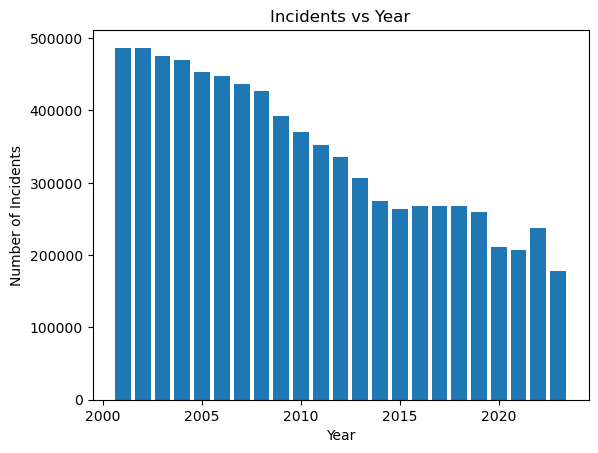

In [12]:
# For each year, what are the number of total incidents
years = []
total_incidents = []
for i in range(0, df.Year.max()+1):
    df_tmp = df.loc[df["Year"] == i]
    if not df_tmp.empty:
        years.append(i)
        total_incidents.append(len(df_tmp))

plt.bar(years, total_incidents)
plt.title("Incidents vs Year")
plt.xlabel('Year')
plt.ylabel('Number of Incidents');

The number of incidents was steadily decreasing from 2001 with the years 2015-19 stable. 2020-2021 were lower which is understandable as that was during COVID-19 lockdowns. There is an increase in incident count in 2022 as society was resuming normal activities. The year 2023 is a lower level but this dataset only includes through September of that year. 

#### Plot Incidents vs Month

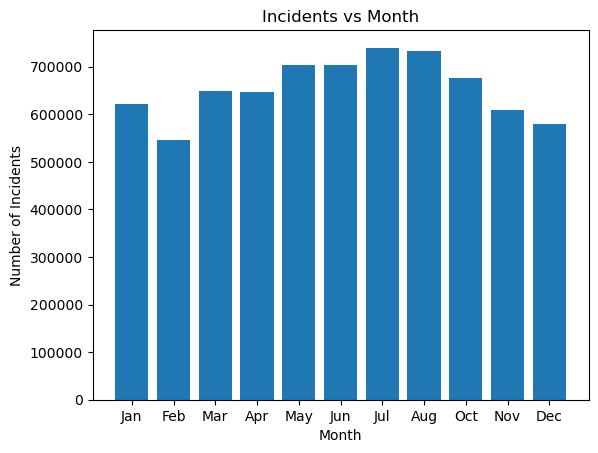

In [13]:
# For each month, what are the number of total incidents
month = []
total_incidents = []
for i in ['Jan', 'Feb', 'Mar', 'Apr','May','Jun','Jul','Aug','Sept','Oct','Nov','Dec']:
    df_tmp = df.loc[df["Month"] == i]
    if not df_tmp.empty:
        month.append(i)
        total_incidents.append(len(df_tmp))

plt.bar(month, total_incidents)
plt.title("Incidents vs Month")
plt.xlabel('Month')
plt.ylabel('Number of Incidents');

The number of incidents per month does not vary widely but we can see Jul and Aug are slightly elevated, while Dec and Feb are lower.

#### Plot Incidents vs Day of Month

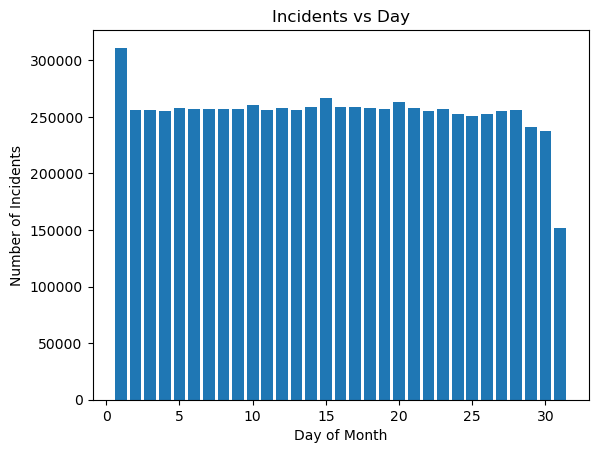

In [14]:
# For each day, what are the number of total incidents
day = []
total_incidents = []
for i in range(1,32):
    df_tmp = df.loc[df["Day"] == i]
    if not df_tmp.empty:
        day.append(i)
        total_incidents.append(len(df_tmp))

plt.bar(day, total_incidents)
plt.title("Incidents vs Day")
plt.xlabel('Day of Month')
plt.ylabel('Number of Incidents');

Interestingly the first of the month is significantly higher in terms of incidents. The 31st day of the month may be lower as not all months have 31 days.

#### Plot Incidents vs Time of Day

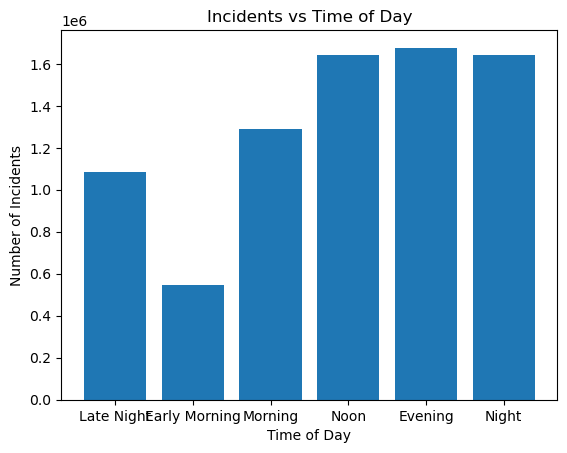

In [15]:
# For each time of day, what are the number of total incidents
time = []
total_incidents = []
for i in ['Late Night','Early Morning','Morning','Noon','Evening','Night']:
    df_tmp = df.loc[df["Time"] == i]
    if not df_tmp.empty:
        time.append(i)
        total_incidents.append(len(df_tmp))

plt.bar(time, total_incidents)
plt.xlabel('Time of Day')
plt.title("Incidents vs Time of Day")
plt.ylabel('Number of Incidents');

The lowest time of crime is early morning (4am-8am), while noon through night (12pm-12am) are fairly consistent.

#### Plot Incidents vs IUCR (Illinois uniform crime reporting code)

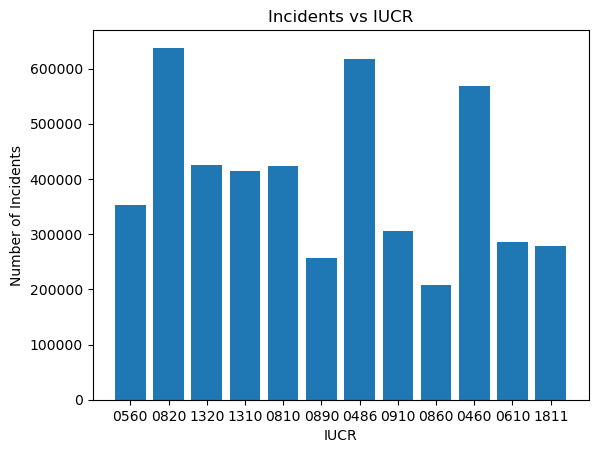

In [16]:
# What are the number of total incidents by IUCR? Limit to over 200,000 incidents.
types = []
total_incidents = []
for i in df.IUCR.unique():
    df_tmp = df.loc[df["IUCR"] == i]
    if not df_tmp.empty:
        if len(df_tmp) > 200000:
            types.append(i)
            total_incidents.append(len(df_tmp))

plt.bar(types, total_incidents)
plt.title("Incidents vs IUCR")
plt.ylabel('Number of Incidents')
plt.xlabel('IUCR');

I plotted IUCR codes for cases where the incidents were over 200,000 so I can see which have the most incidents.

Top 3 IUCR codes are:
* 0820 (Theft - $400 and under)
* 0486 (Battery - Domestic battery simple)
* 0460 (Battery - Simple)

### Examine data for each police district

#### Plot Incidents vs District

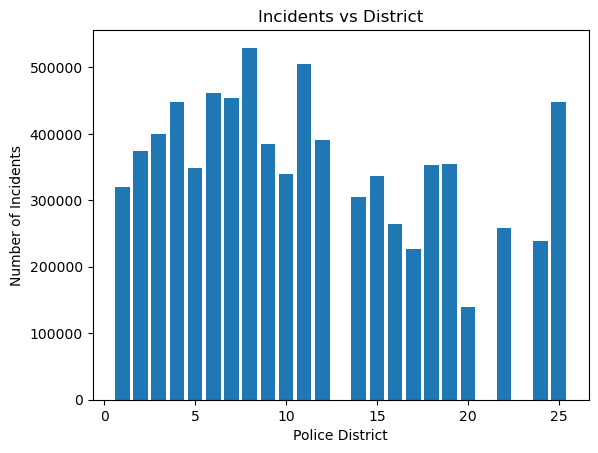

In [17]:
# For each district, what are the number of total incidents
districts = []
total_incidents = []
for i in [1,2,3,4,5,6,7,8,9,10,11,12,14,15,16,17,18,19,20,22,24,25]:
    df_tmp = df.loc[df["District"] == i]
    if not df_tmp.empty:
        districts.append(i)
        total_incidents.append(len(df_tmp))

plt.bar(districts, total_incidents)
plt.title("Incidents vs District")
plt.ylabel('Number of Incidents')
plt.xlabel('Police District');

#### Incidents vs Month (for each district)

District  1


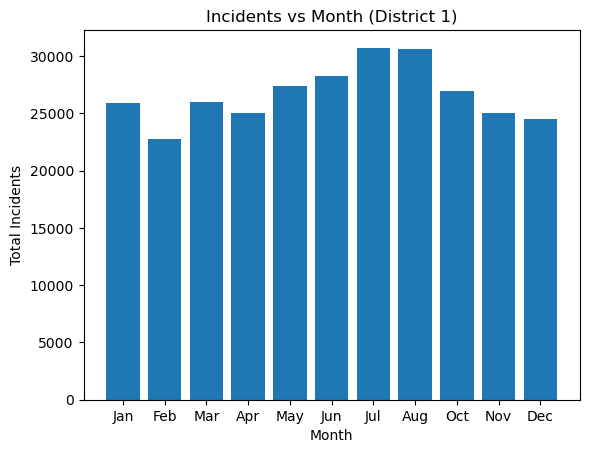

District  2


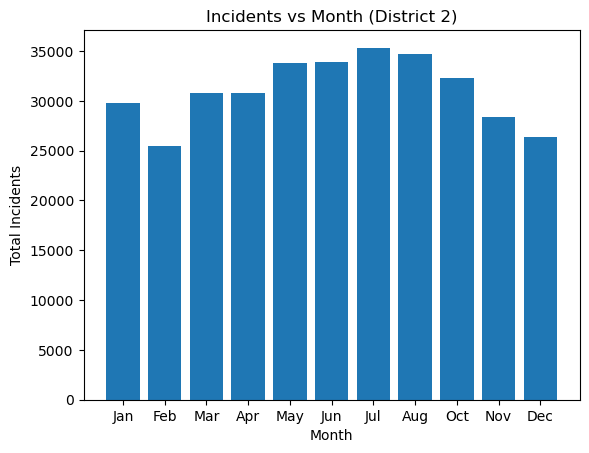

District  3


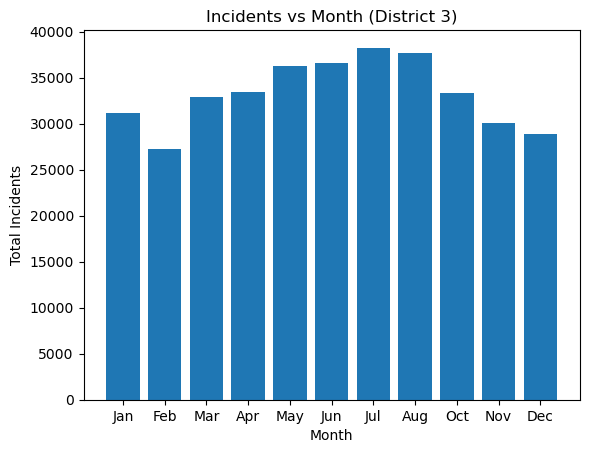

District  4


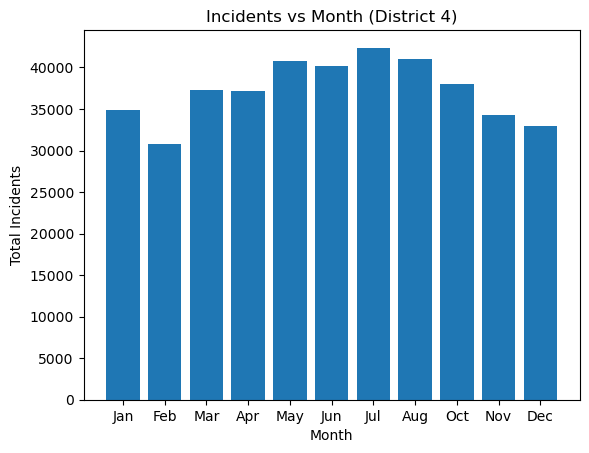

District  5


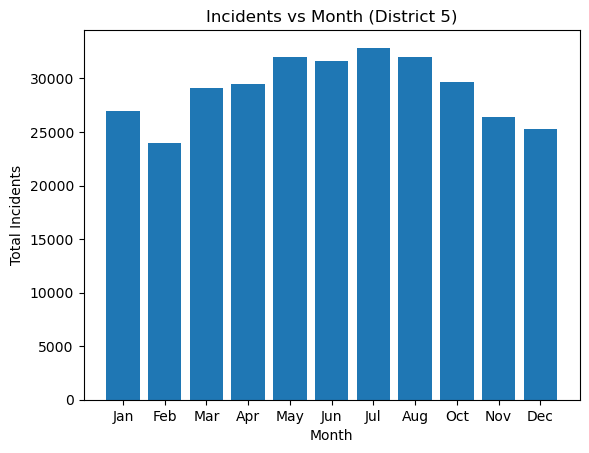

District  6


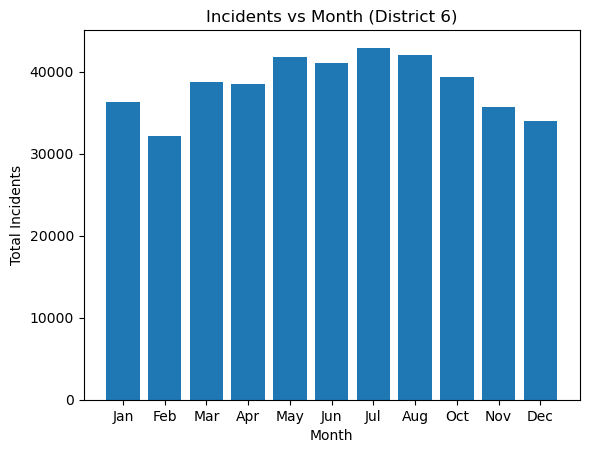

District  7


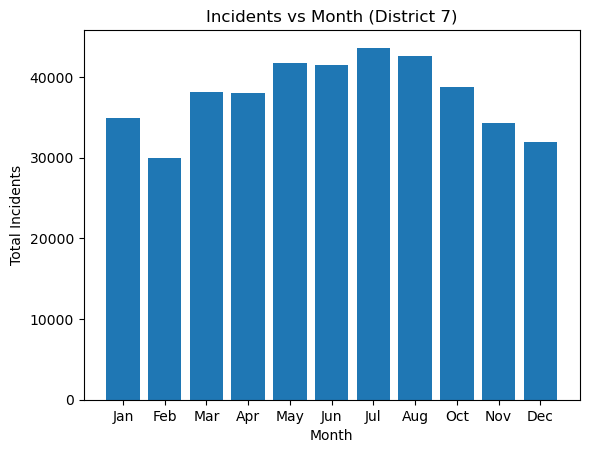

District  8


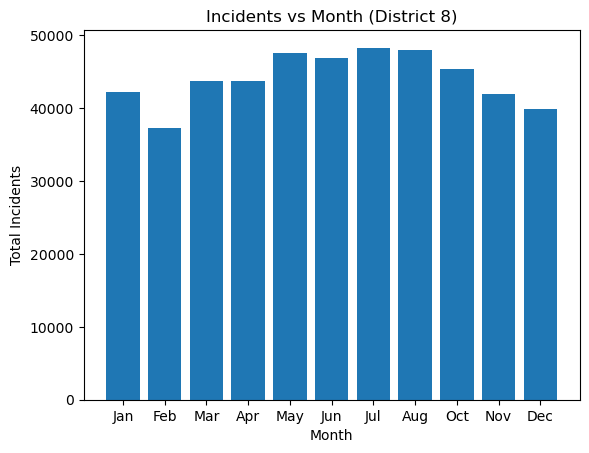

District  9


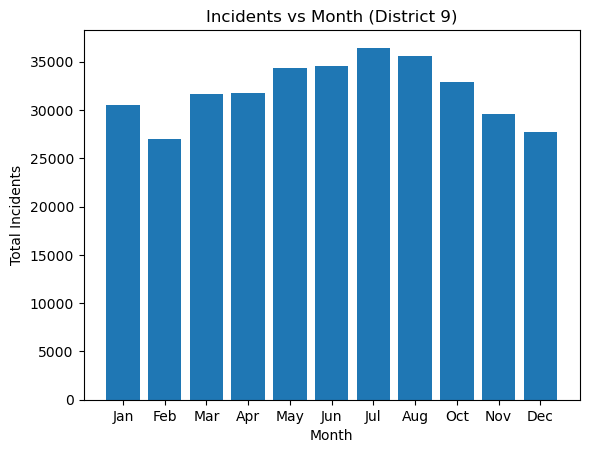

District  10


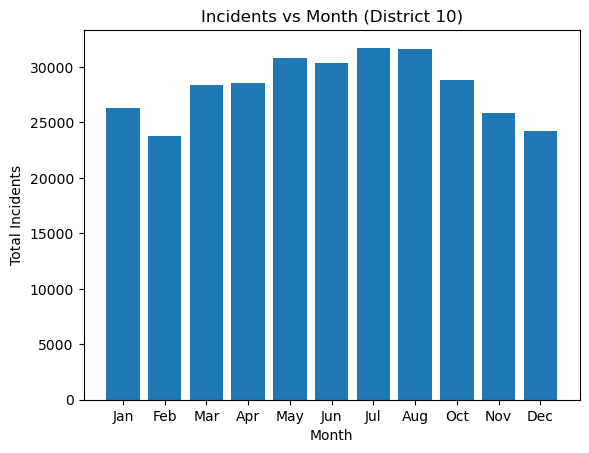

District  11


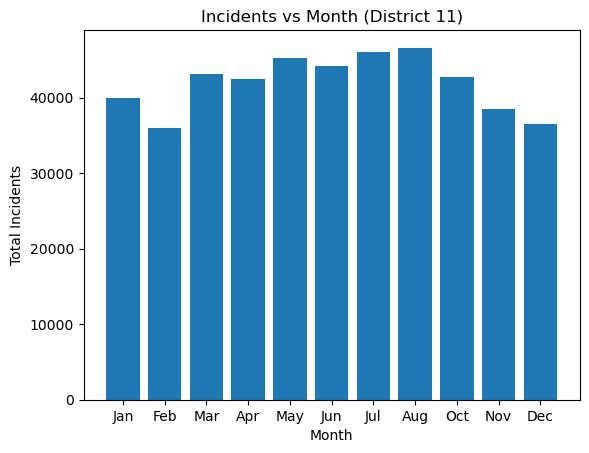

District  12


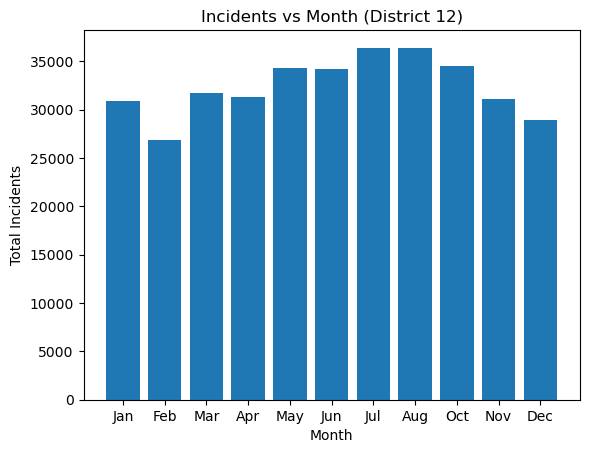

District  14


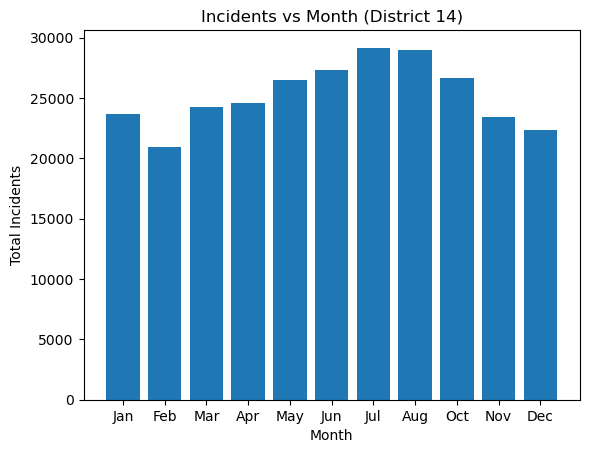

District  15


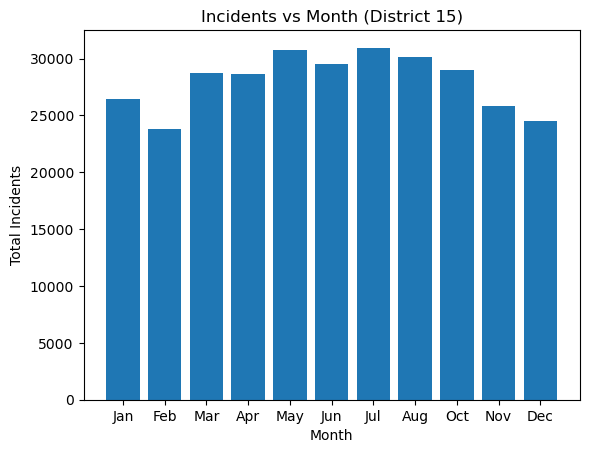

District  16


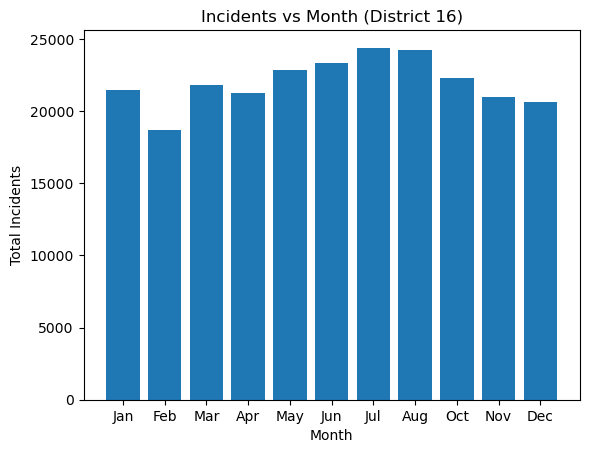

District  17


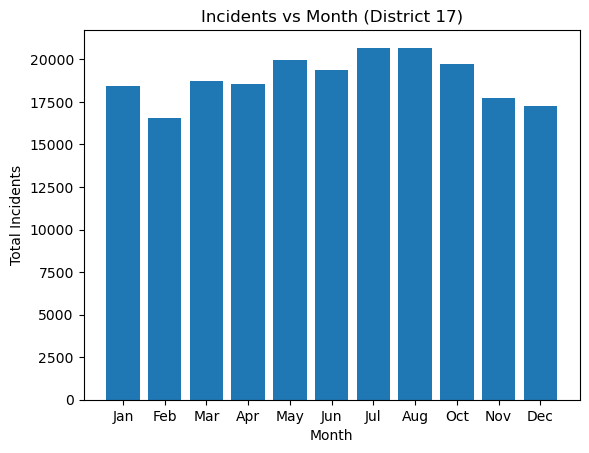

District  18


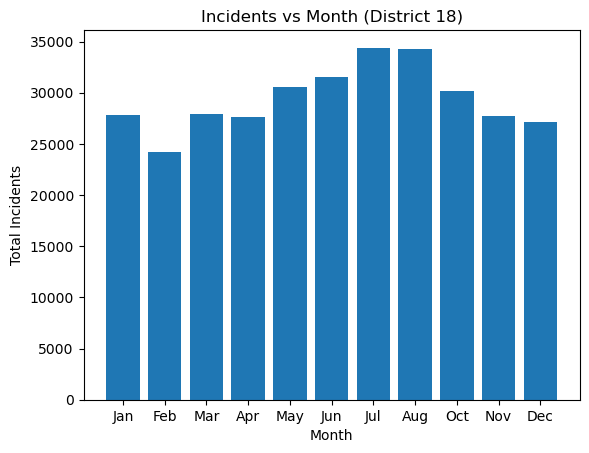

District  19


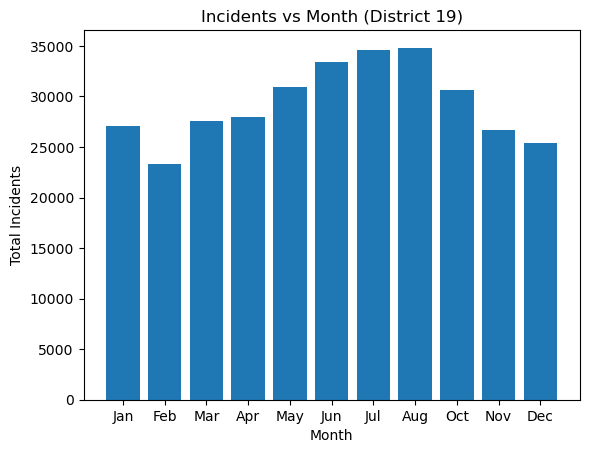

District  20


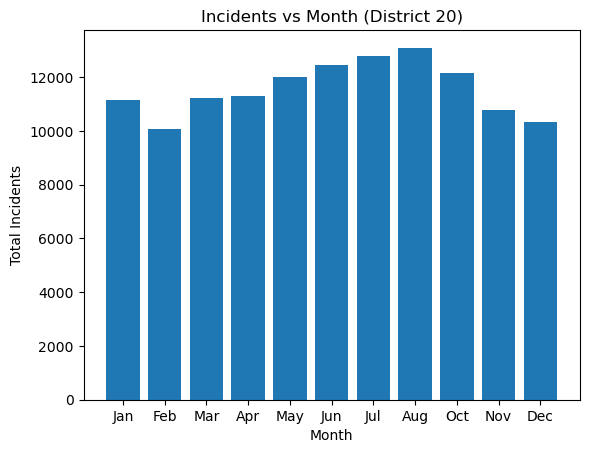

District  22


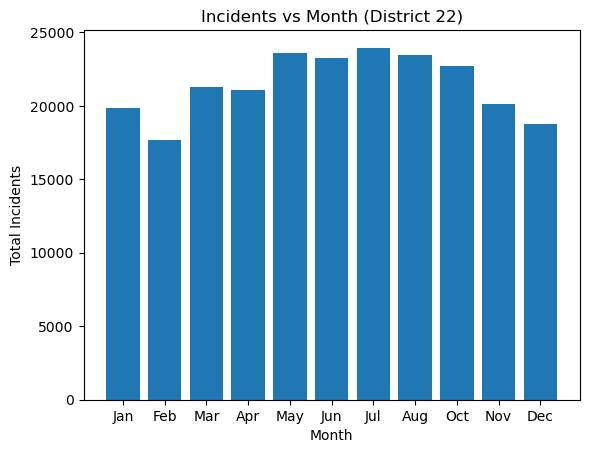

District  24


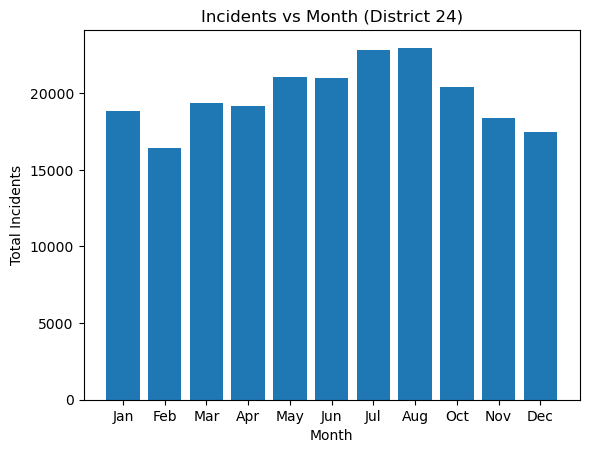

District  25


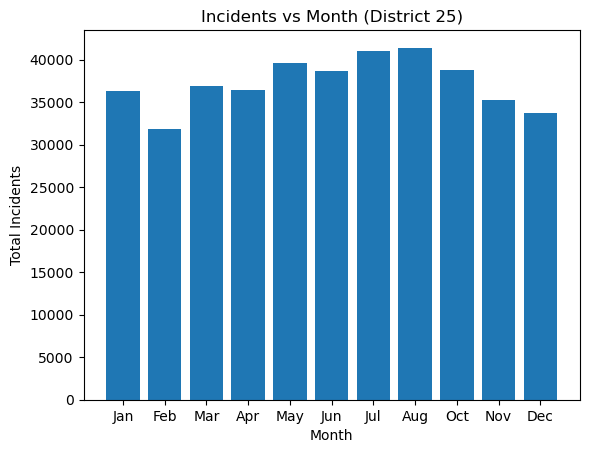

In [18]:
# For each month, what are the number of total incidents for each district
for i in [1,2,3,4,5,6,7,8,9,10,11,12,14,15,16,17,18,19,20,22,24,25]:
    print('District ', i)
    df_tmp = df.loc[df["District"] == i]
    if not df_tmp.empty:
        month = []
        total_incidents = []
        for j in ['Jan', 'Feb', 'Mar', 'Apr','May','Jun','Jul','Aug','Sept','Oct','Nov','Dec']:
            tmp = df_tmp.loc[df_tmp["Month"] == j]
            if not tmp.empty:
                month.append(j)
                total_incidents.append(len(tmp))
        plt.bar(month, total_incidents)
        plt.title("Incidents vs Month (District "+ str(i) + ")")
        plt.ylabel('Total Incidents')
        plt.xlabel('Month')
        plt.show();

#### Incidents vs Day (for each district)

District  1


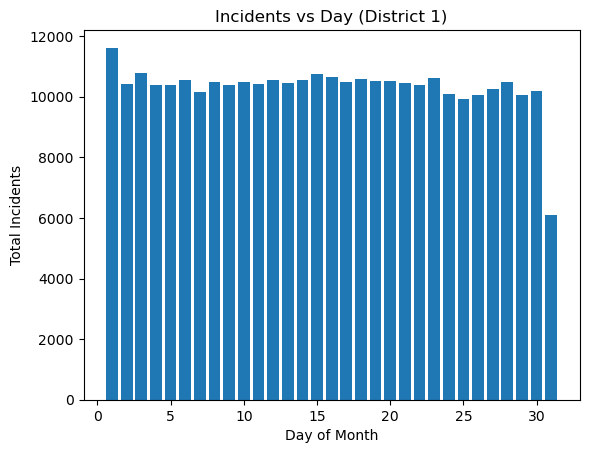

District  2


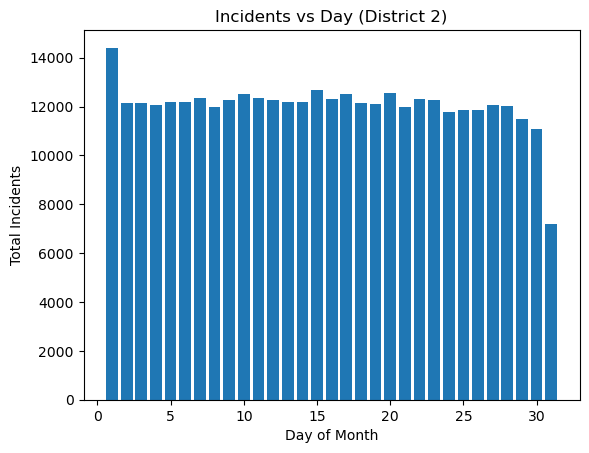

District  3


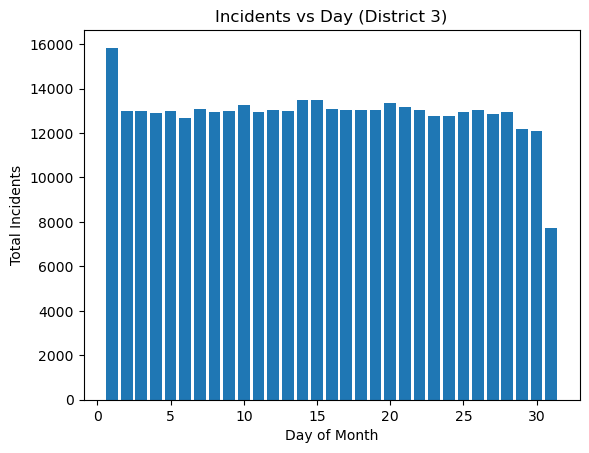

District  4


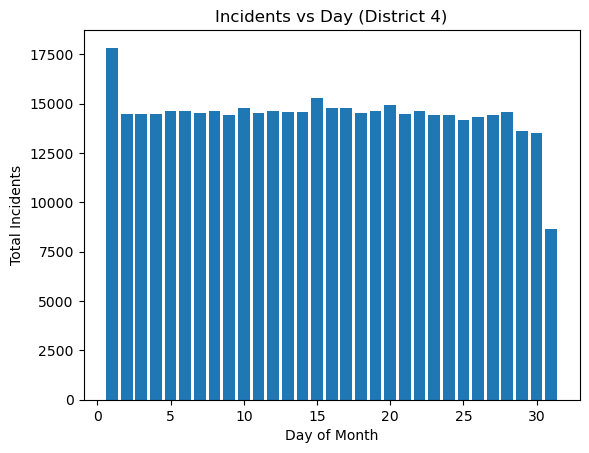

District  5


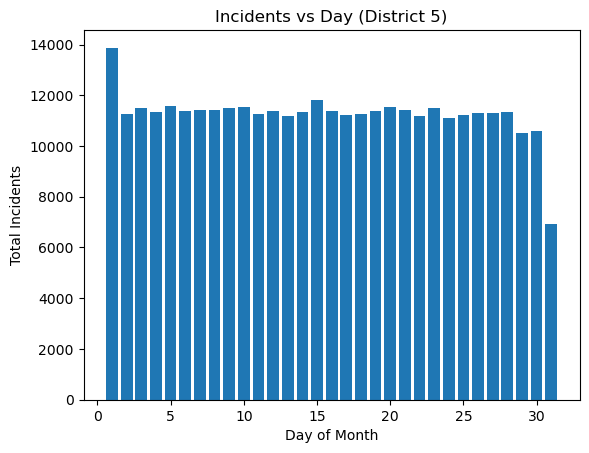

District  6


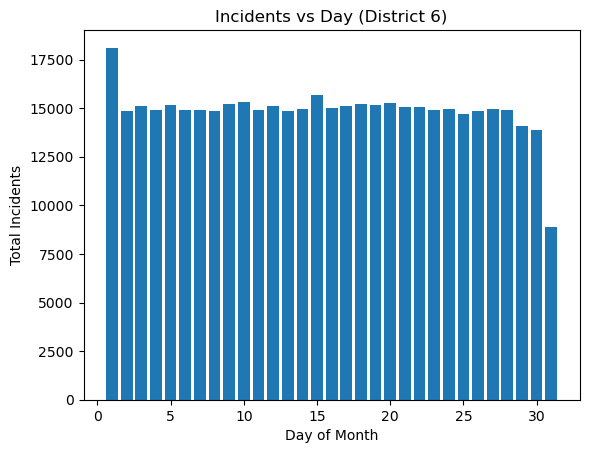

District  7


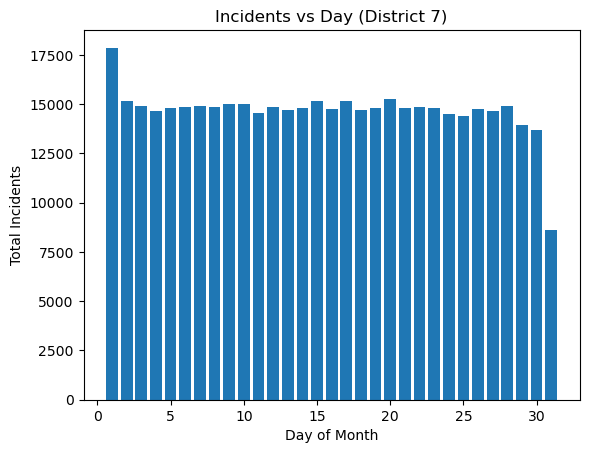

District  8


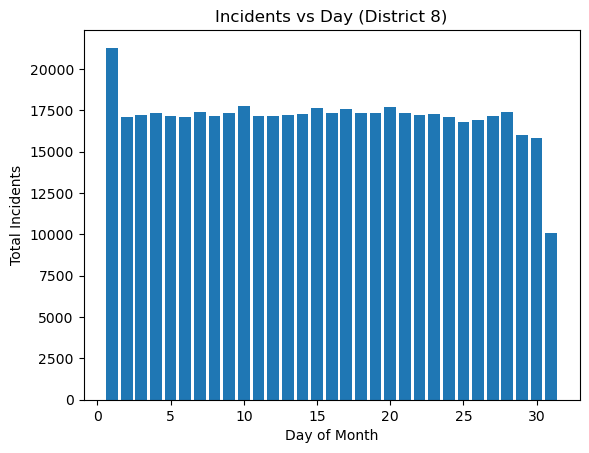

District  9


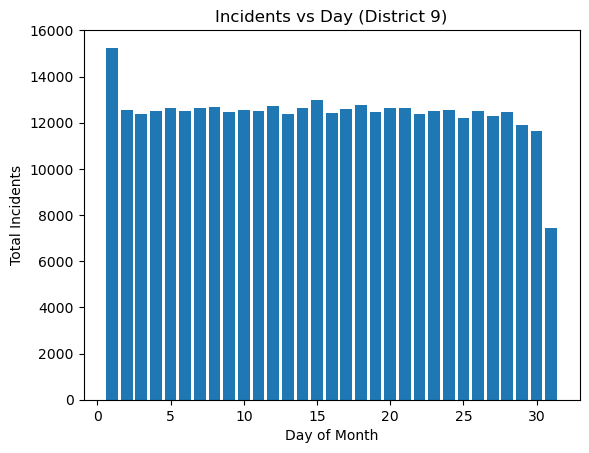

District  10


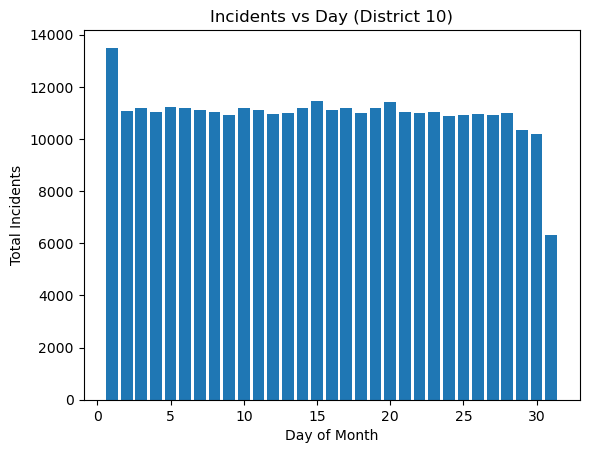

District  11


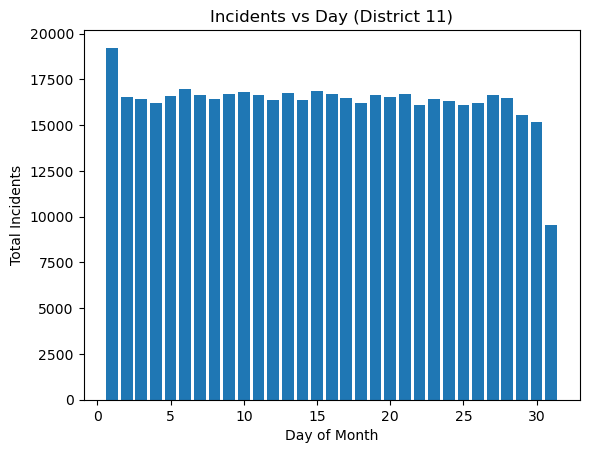

District  12


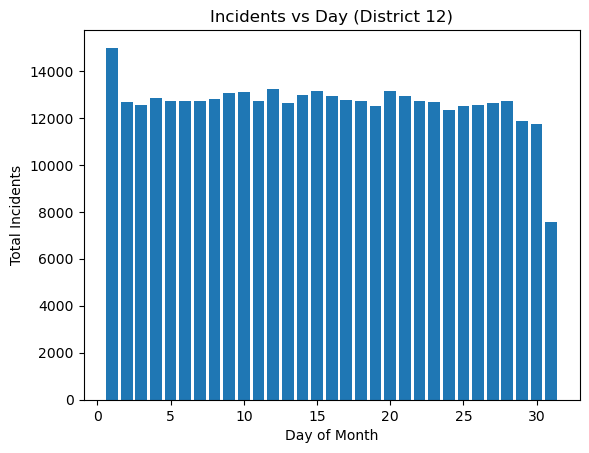

District  14


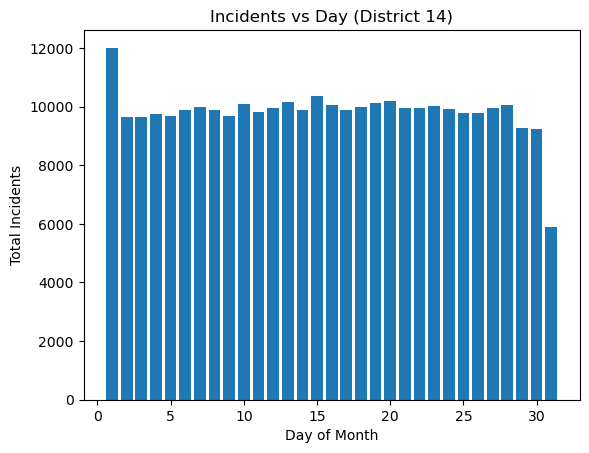

District  15


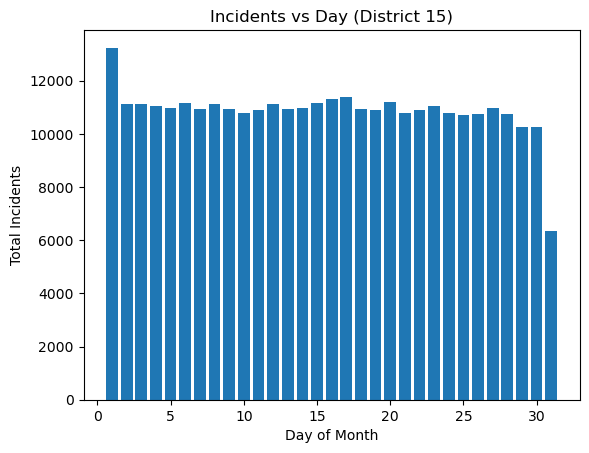

District  16


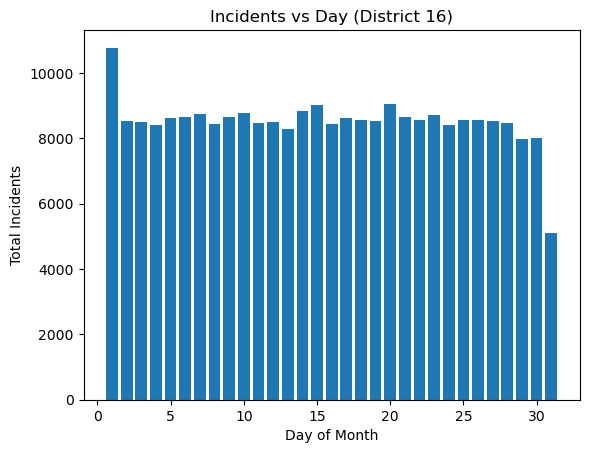

District  17


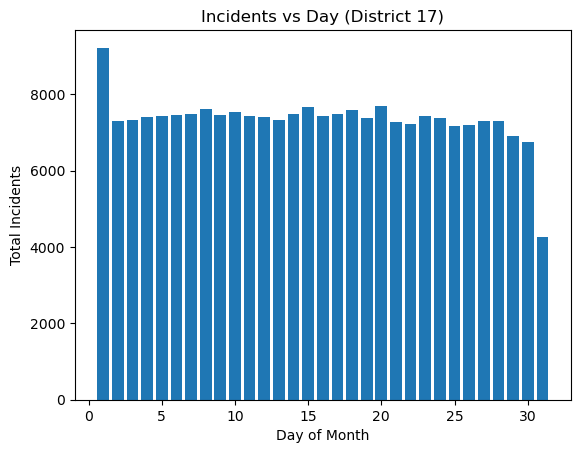

District  18


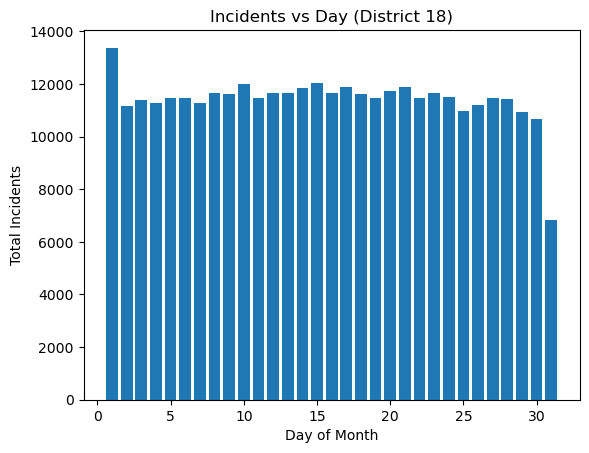

District  19


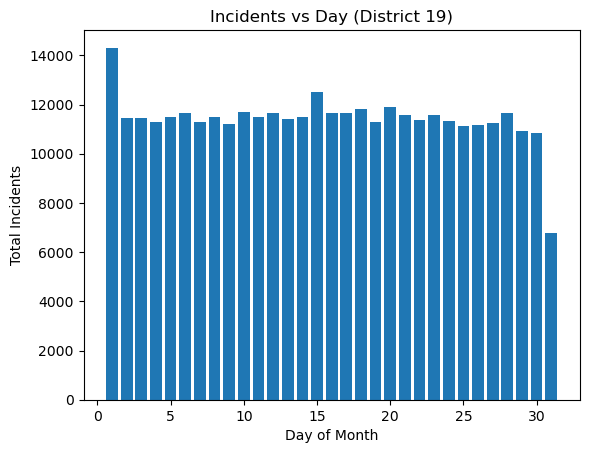

District  20


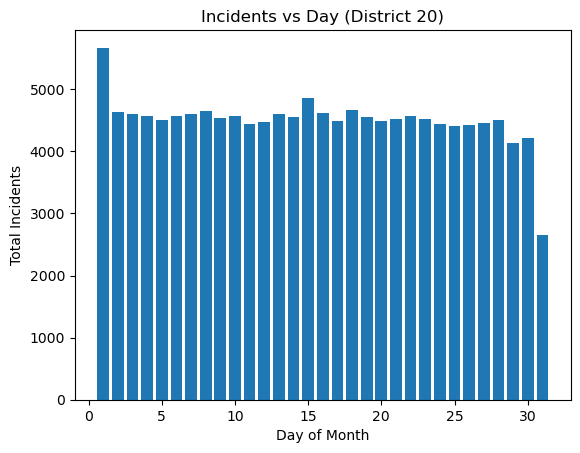

District  22


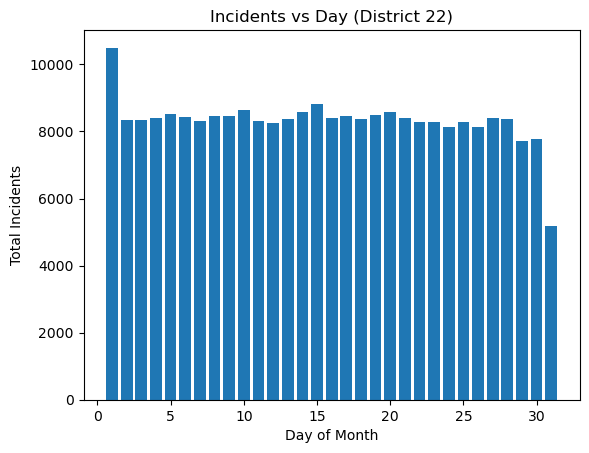

District  24


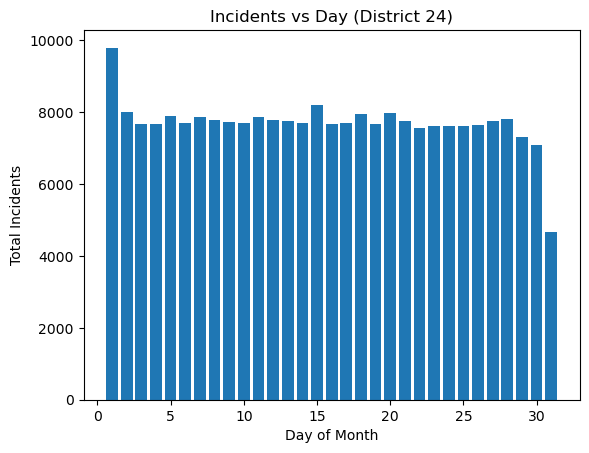

District  25


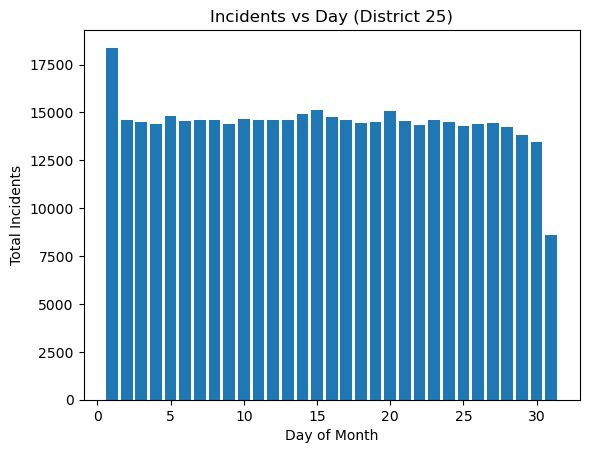

In [19]:
# For each day, what are the number of total incidents for each district
for i in [1,2,3,4,5,6,7,8,9,10,11,12,14,15,16,17,18,19,20,22,24,25]:
    print('District ', i)
    df_tmp = df.loc[df["District"] == i]
    if not df_tmp.empty:
        day = []
        total_incidents = []
        for j in range(1,32):
            tmp = df_tmp.loc[df_tmp["Day"] == j]
            if not tmp.empty:
                day.append(j)
                total_incidents.append(len(tmp))
        plt.bar(day, total_incidents)
        plt.title("Incidents vs Day (District "+ str(i) + ")")
        plt.ylabel('Total Incidents')
        plt.xlabel('Day of Month')
        plt.show();

Data for each district is consistent for month and day.

#### Incidents vs Time of Day (for each district)

District  1


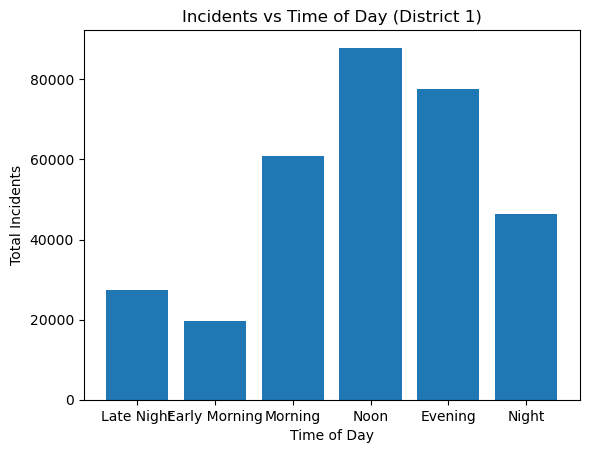

District  2


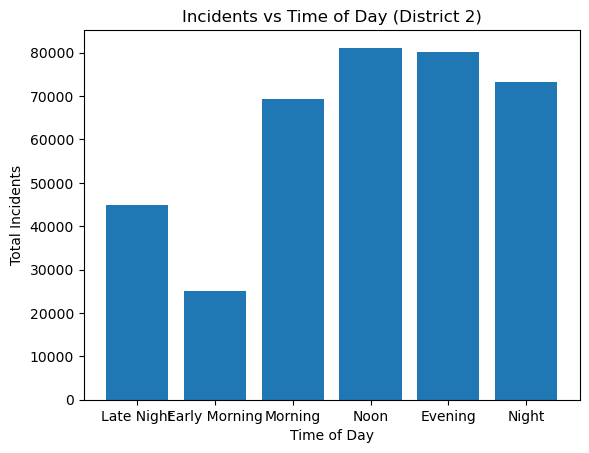

District  3


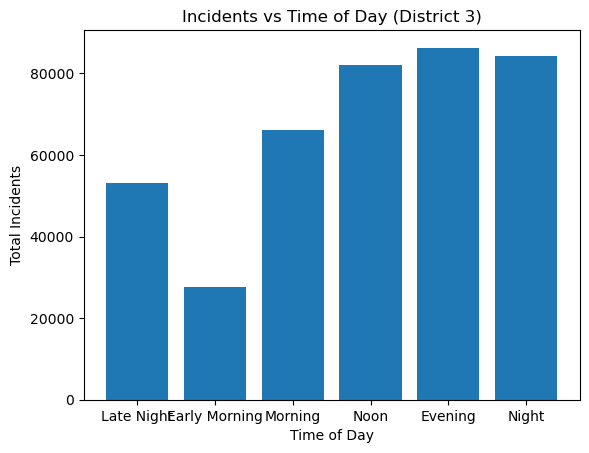

District  4


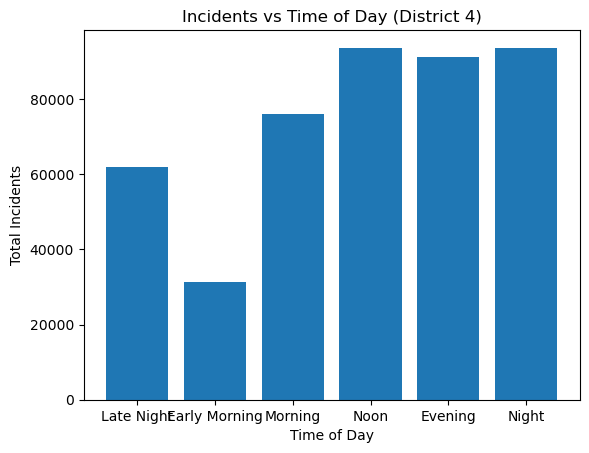

District  5


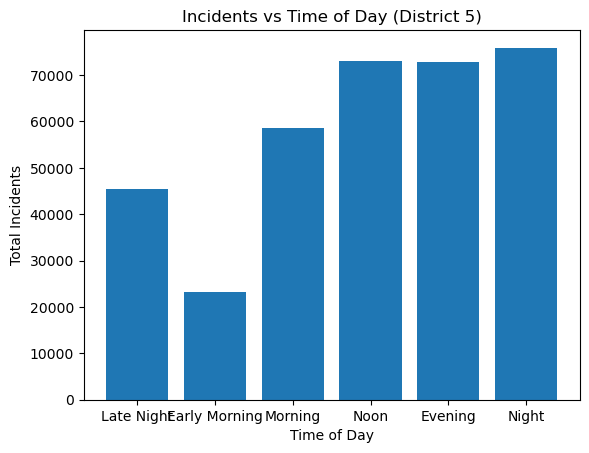

District  6


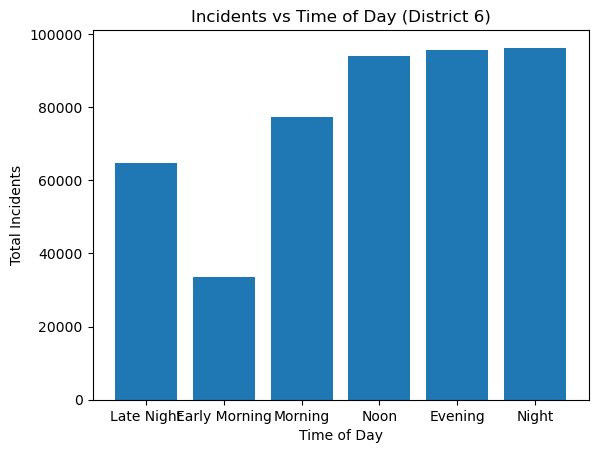

District  7


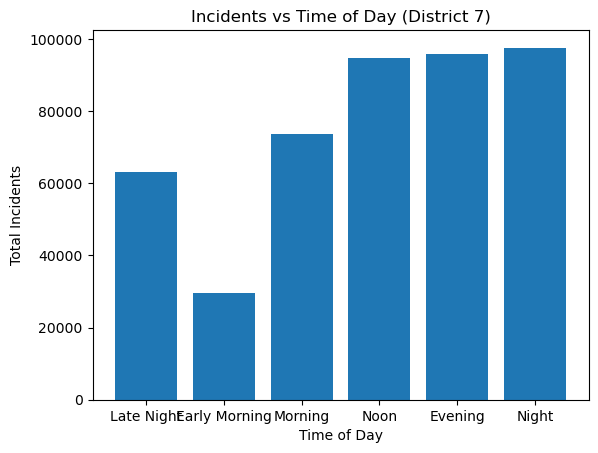

District  8


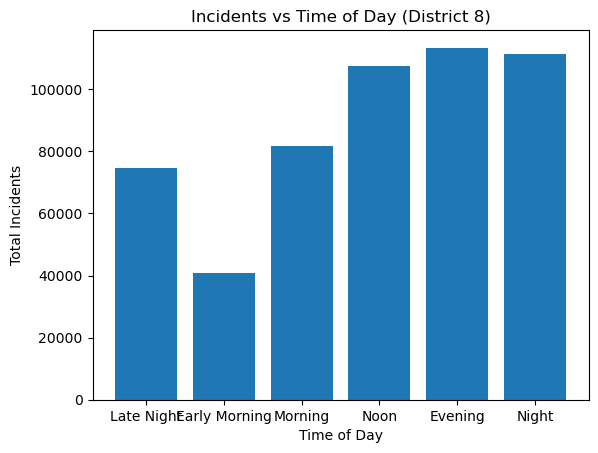

District  9


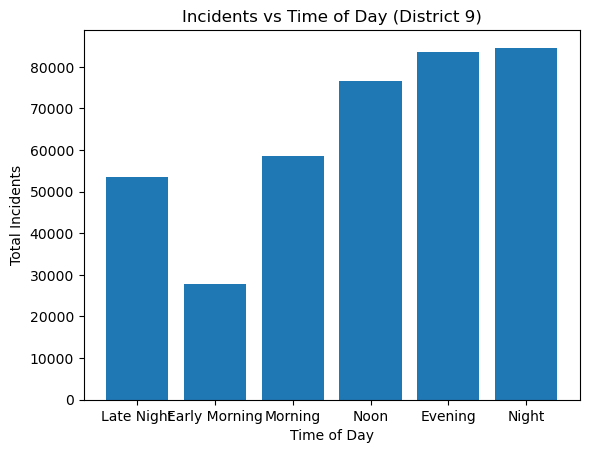

District  10


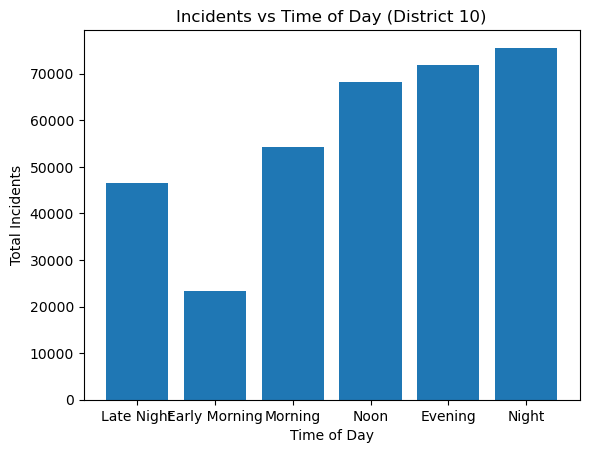

District  11


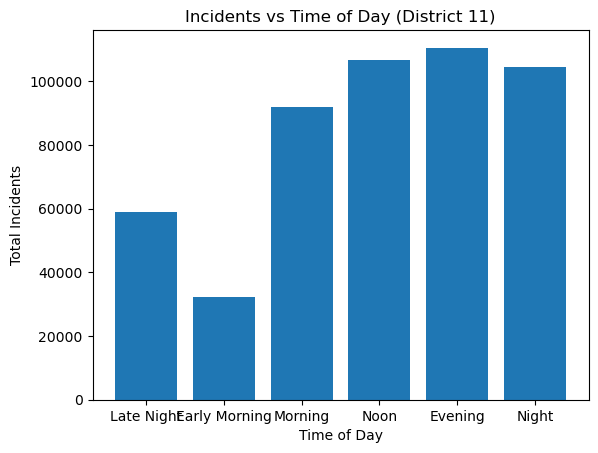

District  12


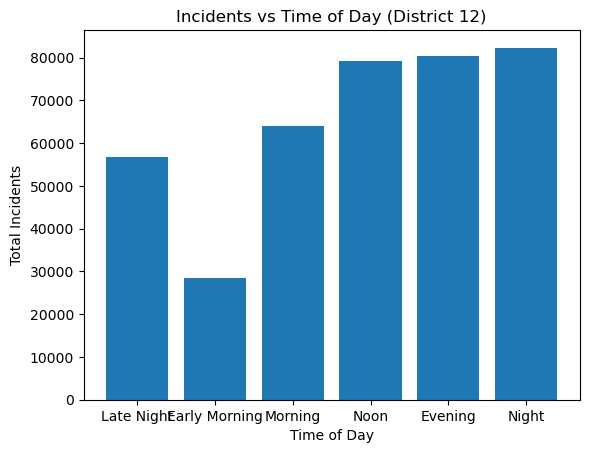

District  14


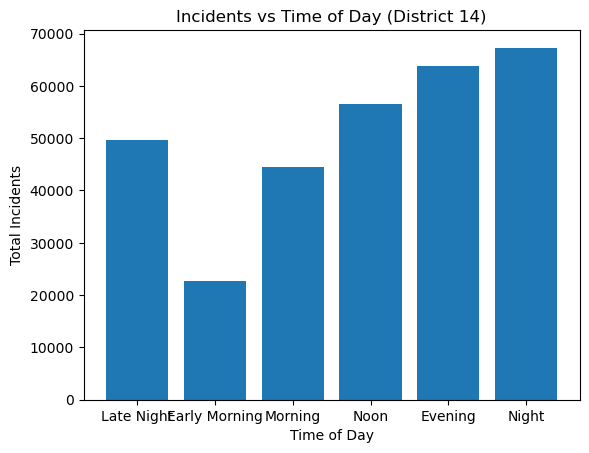

District  15


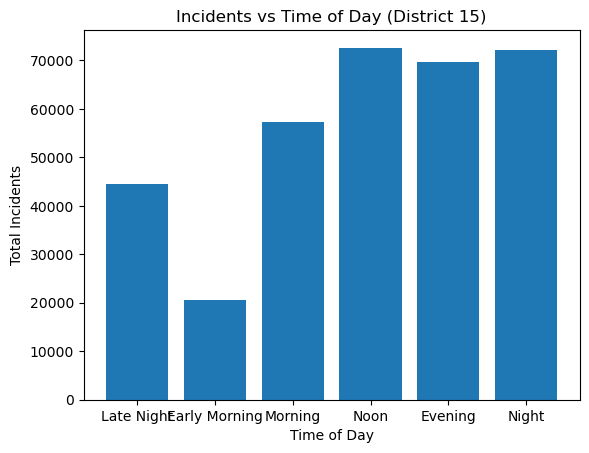

District  16


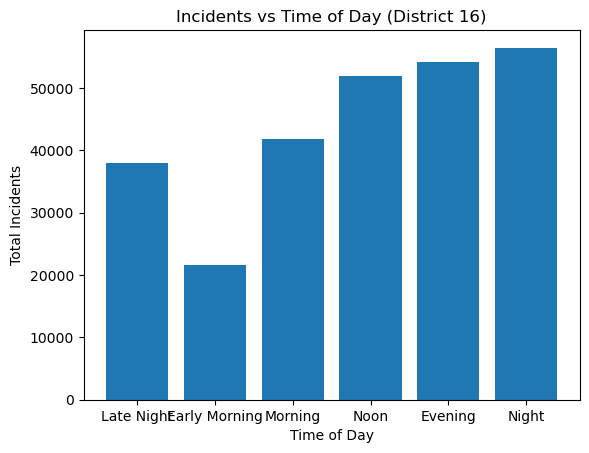

District  17


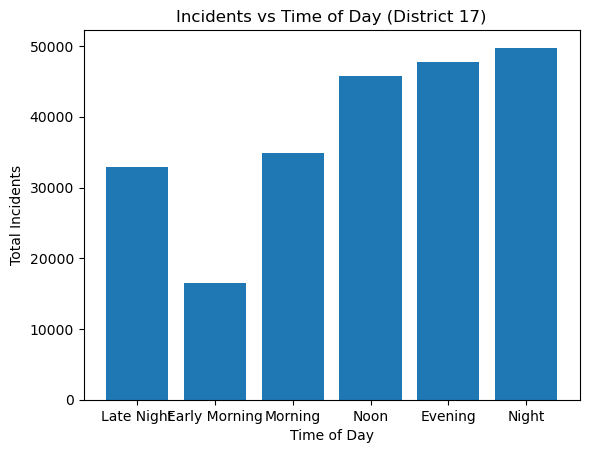

District  18


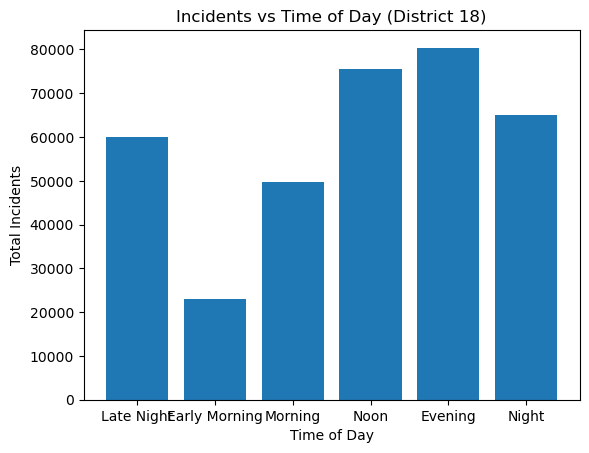

District  19


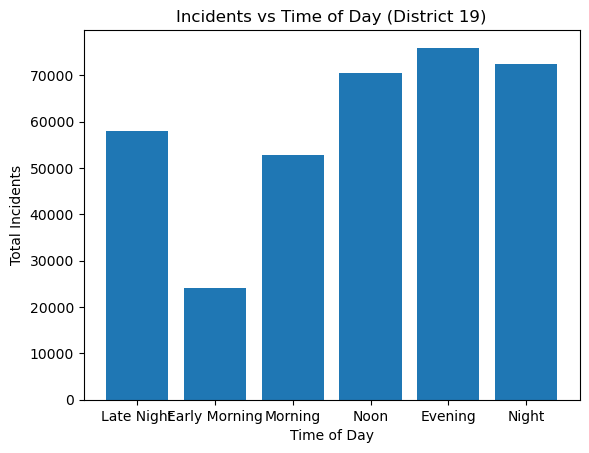

District  20


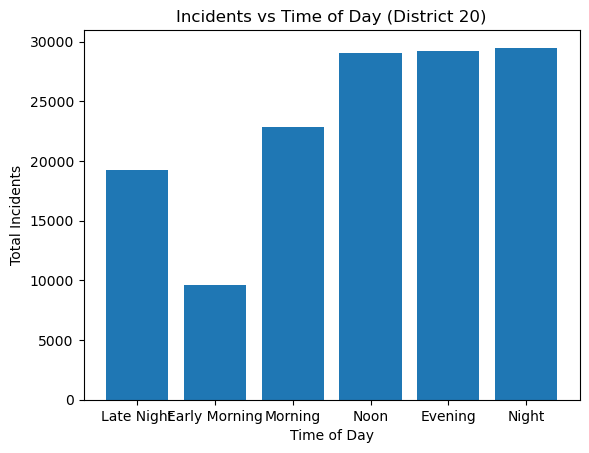

District  22


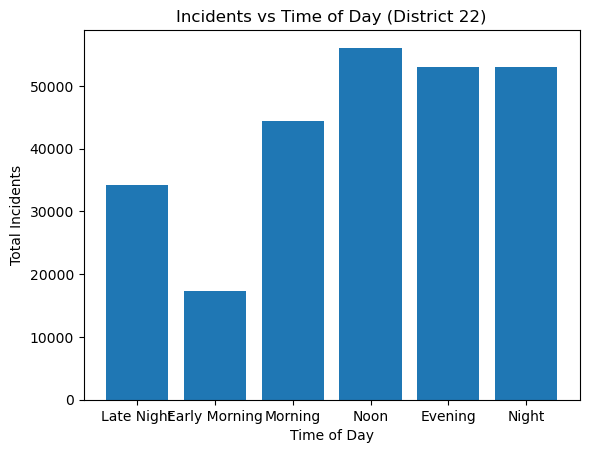

District  24


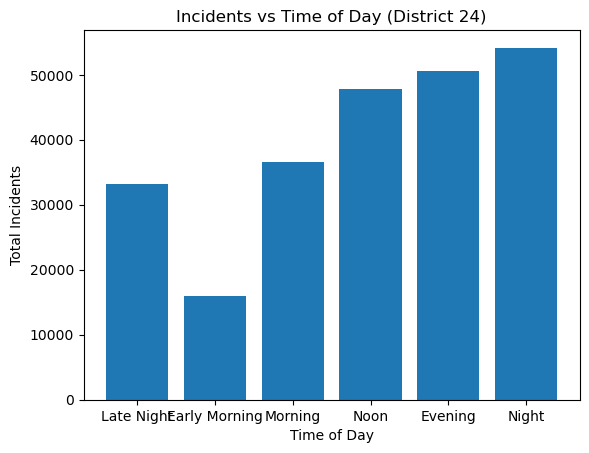

District  25


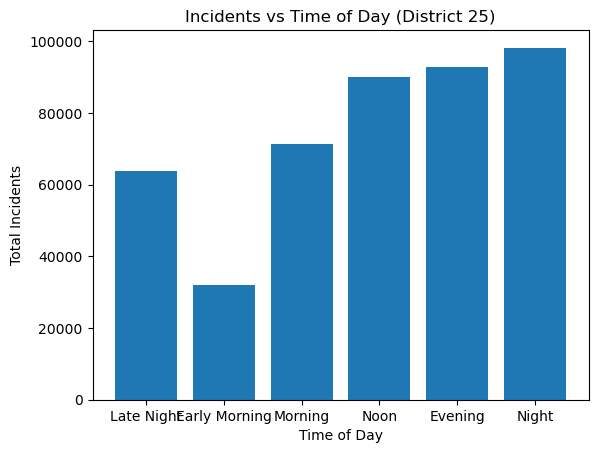

In [20]:
# For each time of day, what are the number of total incidents for each district
for i in [1,2,3,4,5,6,7,8,9,10,11,12,14,15,16,17,18,19,20,22,24,25]:
    print('District ', i)
    df_tmp = df.loc[df["District"] == i]
    if not df_tmp.empty:
        time = []
        total_incidents = []
        for j in ['Late Night','Early Morning','Morning','Noon','Evening','Night']:
            tmp = df_tmp.loc[df_tmp["Time"] == j]
            if not tmp.empty:
                time.append(j)
                total_incidents.append(len(tmp))
        plt.bar(time, total_incidents)
        plt.title("Incidents vs Time of Day (District "+ str(i) + ")")
        plt.ylabel('Total Incidents')
        plt.xlabel('Time of Day')
        plt.show();

For the most part consistent although District 1 has noon leading with Night at a lower percentage than other districts.

#### Incidents vs IUCR (for each district)

District  1


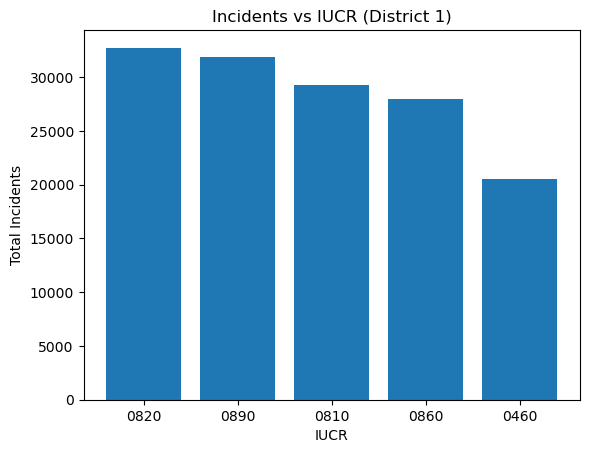

District  2


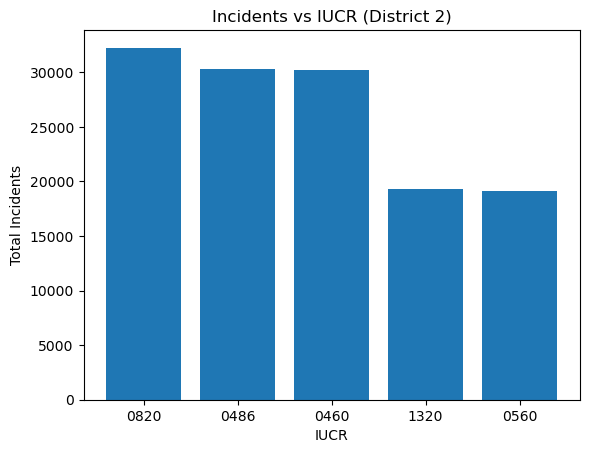

District  3


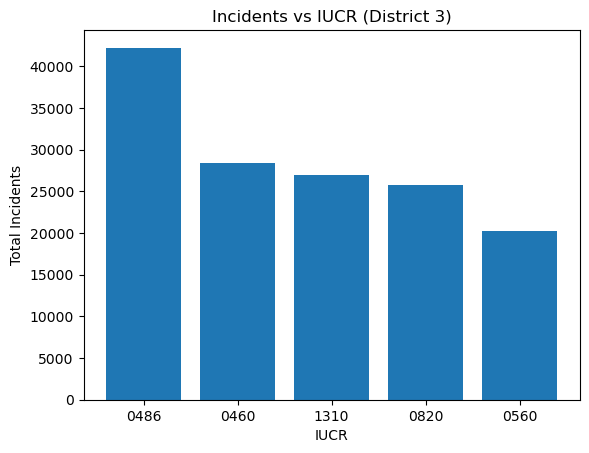

District  4


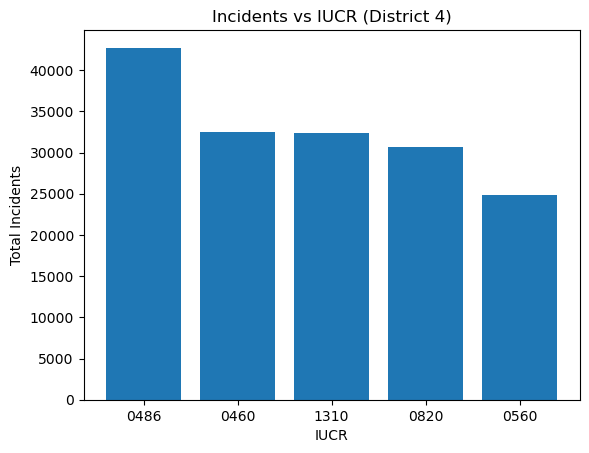

District  5


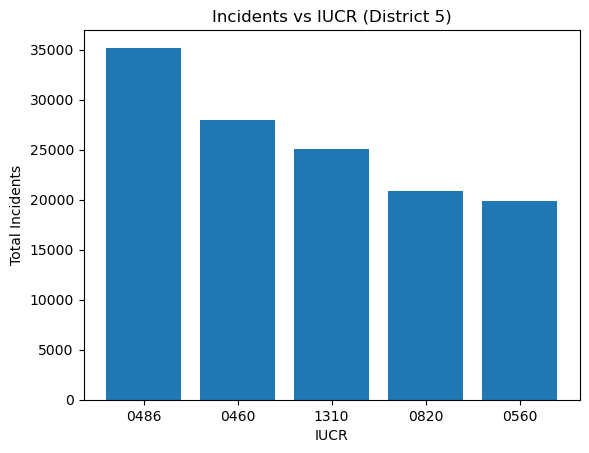

District  6


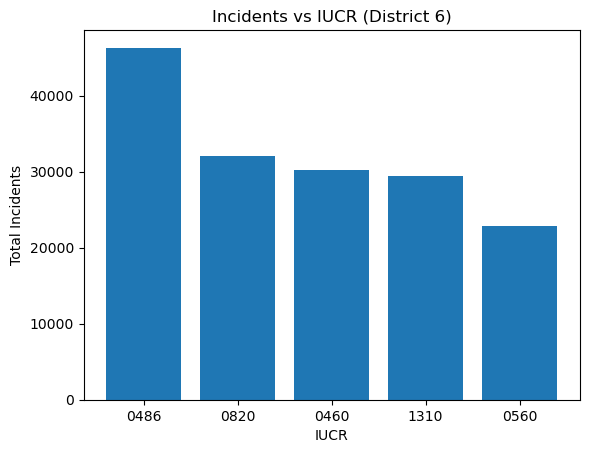

District  7


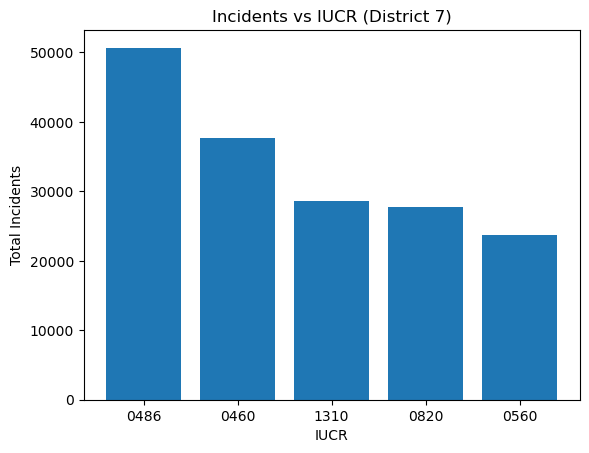

District  8


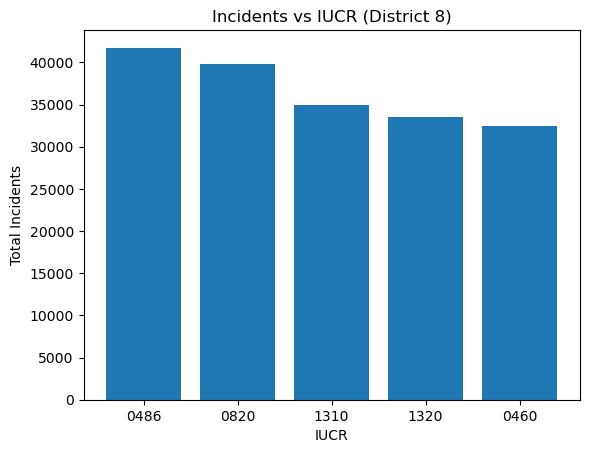

District  9


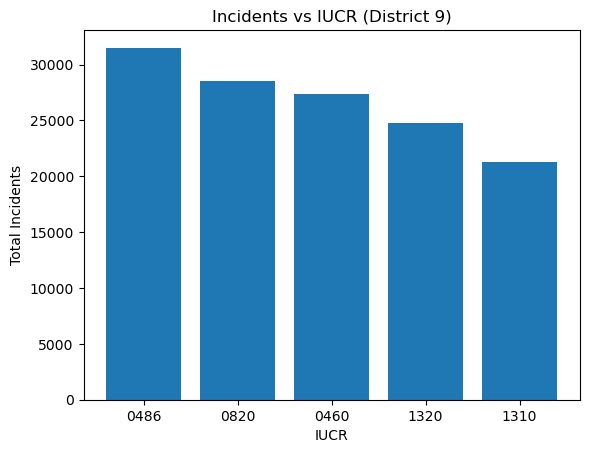

District  10


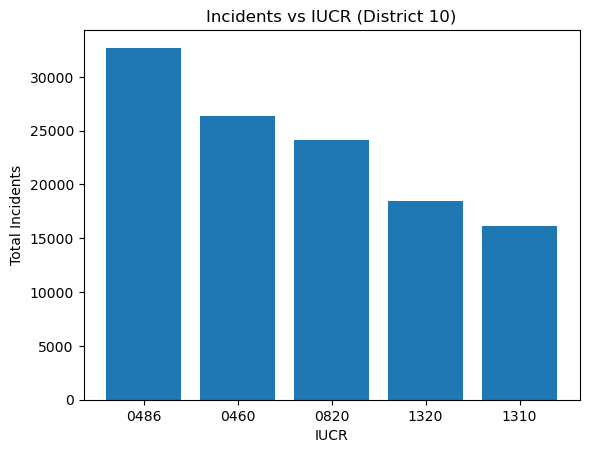

District  11


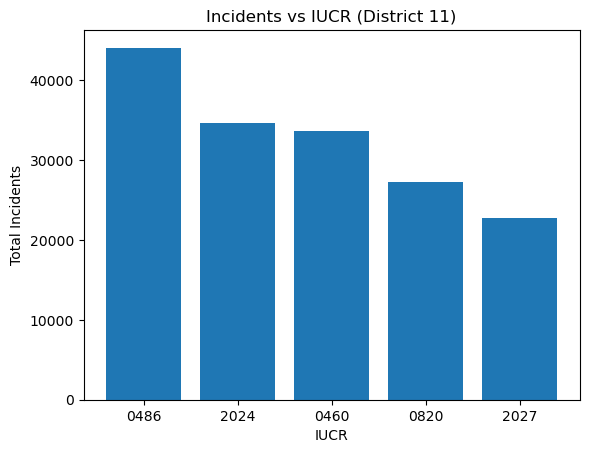

District  12


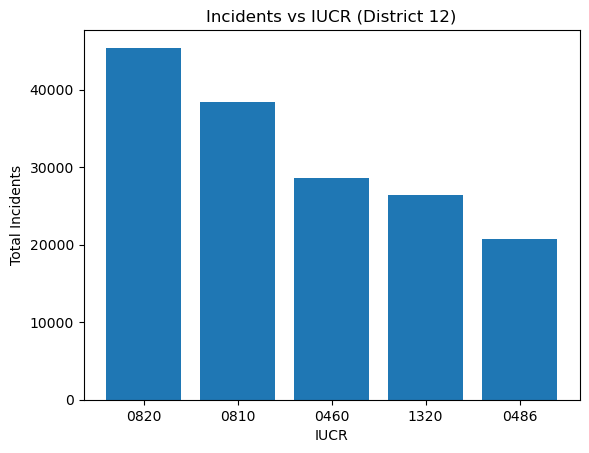

District  14


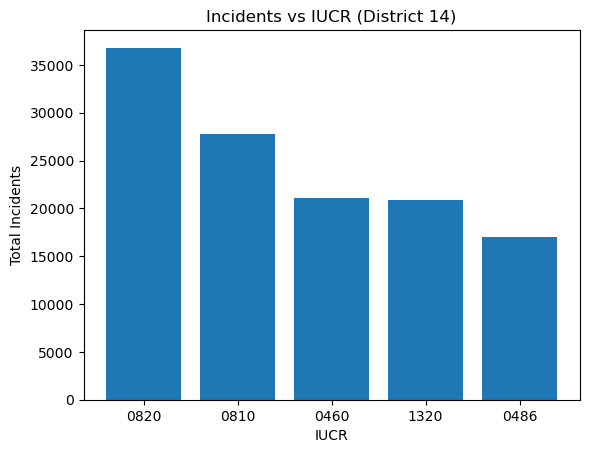

District  15


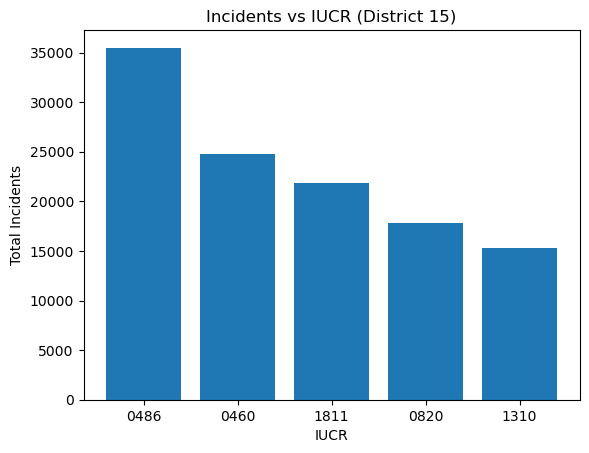

District  16


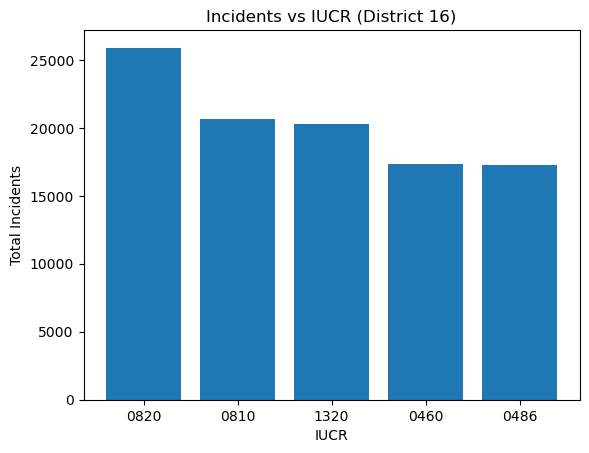

District  17


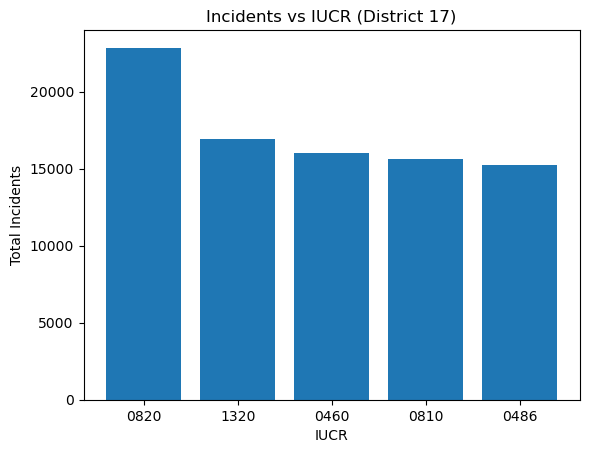

District  18


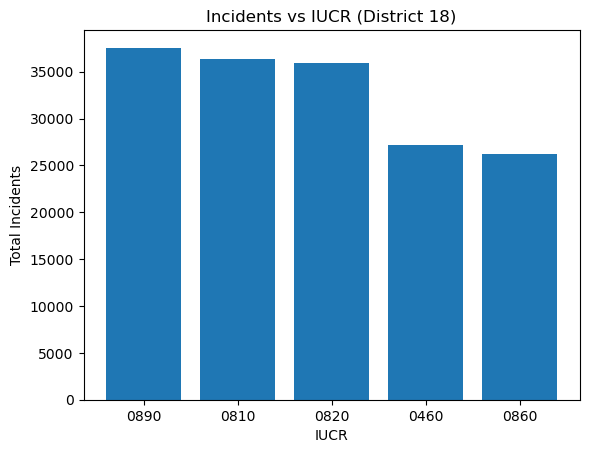

District  19


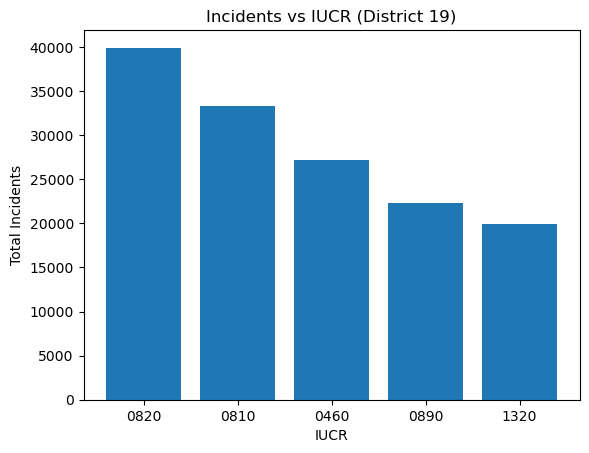

District  20


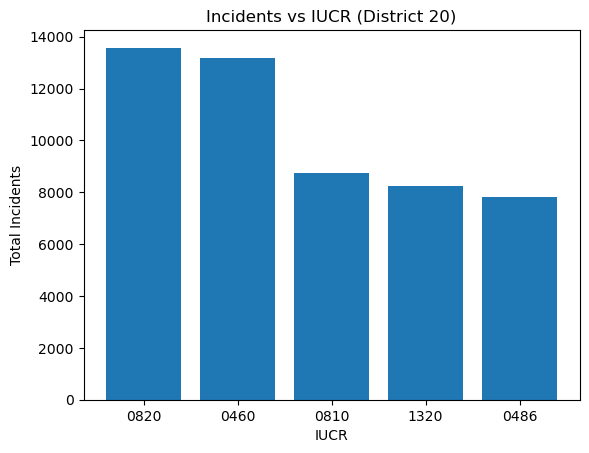

District  22


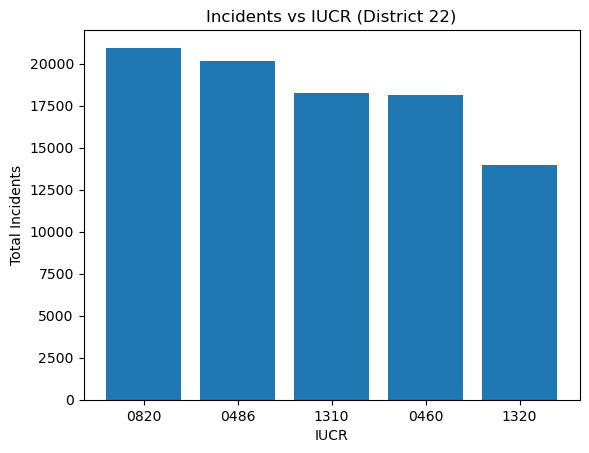

District  24


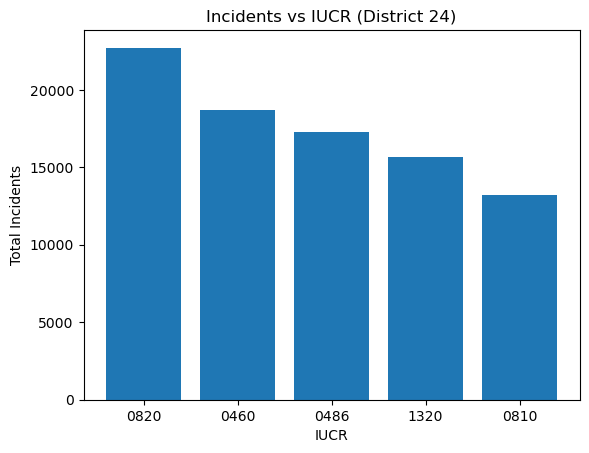

District  25


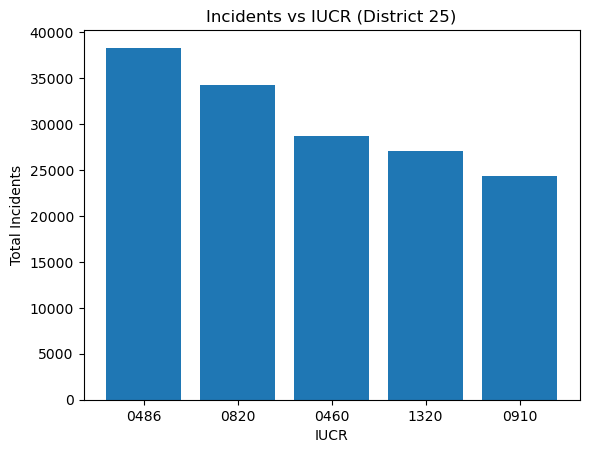

In [21]:
# Show top 5 types of crime for each district
for i in [1,2,3,4,5,6,7,8,9,10,11,12,14,15,16,17,18,19,20,22,24,25]:
    print('District ', i)
    df_tmp = df.loc[df["District"] == i]
    if not df_tmp.empty:
        tmp = df_tmp.groupby(['IUCR']).size().sort_values(ascending=False)[0:5]
        plt.bar(tmp.index, tmp.values)
        plt.title("Incidents vs IUCR (District "+ str(i) + ")")
        plt.ylabel('Total Incidents')
        plt.xlabel('IUCR')
        plt.show();

## Association Rule Mining

### Generate frequent itemsets and association rules on the full dataset

In [22]:
# One hot encode to use with Apriori algorithm
df_onehot_type = pd.get_dummies(df['Primary Type'], prefix='Type')
df_onehot_description = pd.get_dummies(df['Description'], prefix='Description')
df_onehot_location = pd.get_dummies(df['Location Description'], prefix='Location')
df_onehot_district = pd.get_dummies(df['District'], prefix='District')
df_onehot_domestic = df['Domestic']
df_onehot_arrest = df['Arrest']
df_onehot_year = pd.get_dummies(df['Year'], prefix="Year")
df_onehot_month = pd.get_dummies(df['Month'], prefix="Month")
df_onehot_day = pd.get_dummies(df['Day'], prefix="Day")
df_onehot_time = pd.get_dummies(df['Time'], prefix="Time")
df_onehot_beat = pd.get_dummies(df['Beat'], prefix='Beat')
df_onehot = pd.concat([df_onehot_type, df_onehot_location, df_onehot_domestic, df_onehot_arrest, df_onehot_time], axis=1)

#### Generate frequent itemsets using the Apriori algorithm

In [23]:
freq_items_full = apriori(df_onehot, min_support=0.06, use_colnames=True)
print(freq_items_full)

     support                        itemsets
0   0.065556                  (Type_ASSAULT)
1   0.182901                  (Type_BATTERY)
2   0.114170          (Type_CRIMINAL DAMAGE)
3   0.095123                (Type_NARCOTICS)
4   0.062137            (Type_OTHER OFFENSE)
5   0.211258                    (Type_THEFT)
6   0.114037            (Location_APARTMENT)
7   0.167367            (Location_RESIDENCE)
8   0.093236             (Location_SIDEWALK)
9   0.261282               (Location_STREET)
10  0.172042                      (Domestic)
11  0.259832                        (Arrest)
12  0.069283            (Time_Early Morning)
13  0.212787                  (Time_Evening)
14  0.137644               (Time_Late Night)
15  0.163511                  (Time_Morning)
16  0.208575                    (Time_Night)
17  0.208201                     (Time_Noon)
18  0.096952        (Type_BATTERY, Domestic)
19  0.094535        (Arrest, Type_NARCOTICS)
20  0.063863  (Domestic, Location_RESIDENCE)
21  0.0708

#### Generate association rules

Remove rules with a lift less than or equal to 1.

In [24]:
# Generate association rules
rules_full = association_rules(freq_items_full, metric="confidence", min_threshold=0.05)

# Remove rules with a lift less than or equal to 1
idx_rules_full = rules_full.index[rules_full['lift'] <=1 ].tolist()
rules_full = rules_full.drop(idx_rules_full)

print(rules_full)

             antecedents           consequents  antecedent support  \
0         (Type_BATTERY)            (Domestic)            0.182901   
1             (Domestic)        (Type_BATTERY)            0.172042   
2               (Arrest)      (Type_NARCOTICS)            0.259832   
3       (Type_NARCOTICS)              (Arrest)            0.095123   
4             (Domestic)  (Location_RESIDENCE)            0.172042   
5   (Location_RESIDENCE)            (Domestic)            0.167367   
6      (Location_STREET)              (Arrest)            0.261282   
7               (Arrest)     (Location_STREET)            0.259832   
8      (Location_STREET)          (Time_Night)            0.261282   
9           (Time_Night)     (Location_STREET)            0.208575   
10              (Arrest)          (Time_Night)            0.259832   
11          (Time_Night)              (Arrest)            0.208575   

    consequent support   support  confidence      lift  leverage  conviction  \
0        

#### Visualize association rules with a directed graph

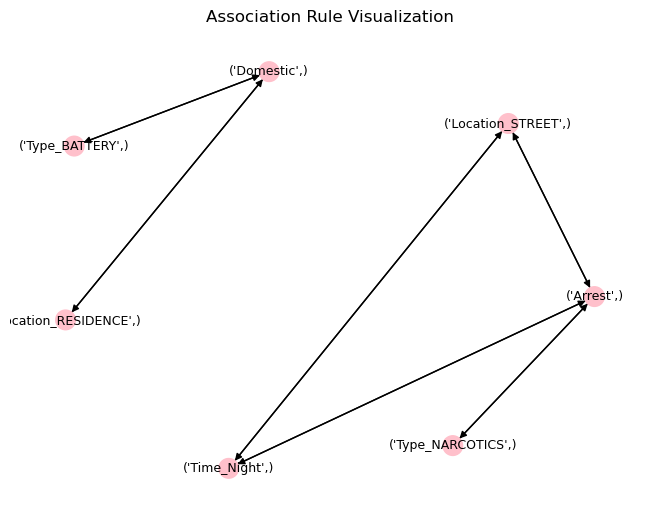

In [25]:
# Create a directed graph
G = nx.DiGraph()

# Add nodes
for item in rules_full['antecedents']:
    G.add_node(tuple(item), color='lightblue')
for item in rules_full['consequents']:
    G.add_node(tuple(item), color='pink')

colors = [node[1]['color'] for node in G.nodes(data=True)]

# Add edges
for idx, row in rules_full.iterrows():
    G.add_edge(tuple(row['antecedents']), tuple(row['consequents']))

# Plot the graph
pos = nx.spring_layout(G, k=4,seed=7)
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw(G, pos, with_labels=True, node_size=200, font_size=9, node_color=colors)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=9)
plt.title("Association Rule Visualization")
plt.show();

### Generate frequent itemsets and association rules for each district

District  1
      antecedents     consequents  antecedent support  consequent support  \
0  (Time_Evening)    (Type_THEFT)            0.242867            0.433307   
1    (Type_THEFT)  (Time_Evening)            0.433307            0.242867   
2     (Time_Noon)    (Type_THEFT)            0.274839            0.433307   
3    (Type_THEFT)     (Time_Noon)            0.433307            0.274839   

    support  confidence      lift  leverage  conviction  zhangs_metric  
0  0.119936    0.493832  1.139682  0.014700    1.119575       0.161877  
1  0.119936    0.276791  1.139682  0.014700    1.046908       0.216276  
2  0.142911    0.519980  1.200026  0.023821    1.180561       0.229859  
3  0.142911    0.329814  1.200026  0.023821    1.082029       0.294136  


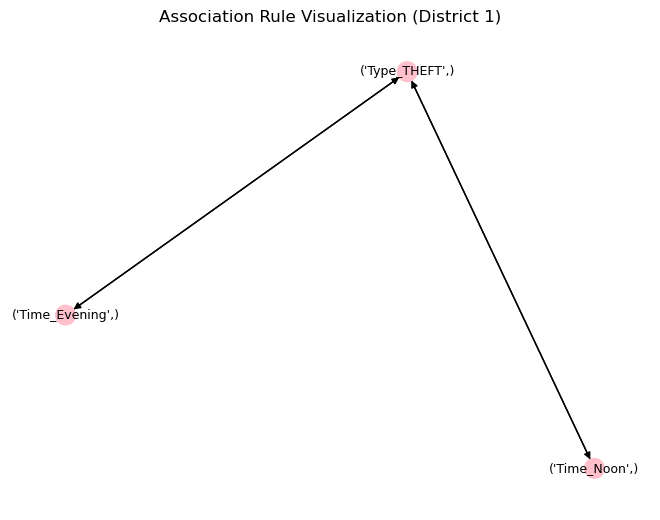

District  2
        antecedents       consequents  antecedent support  consequent support  \
0    (Type_BATTERY)        (Domestic)            0.199709            0.186509   
1        (Domestic)    (Type_BATTERY)            0.186509            0.199709   
2          (Arrest)  (Type_NARCOTICS)            0.258665            0.093723   
3  (Type_NARCOTICS)          (Arrest)            0.093723            0.258665   

    support  confidence      lift  leverage  conviction  zhangs_metric  
0  0.105699    0.529265  2.837740  0.068451    1.728129       0.809214  
1  0.105699    0.566721  2.837740  0.068451    1.847059       0.796084  
2  0.092770    0.358649  3.826681  0.068527    1.413075       0.996414  
3  0.092770    0.989828  3.826681  0.068527   72.881980       0.815068  


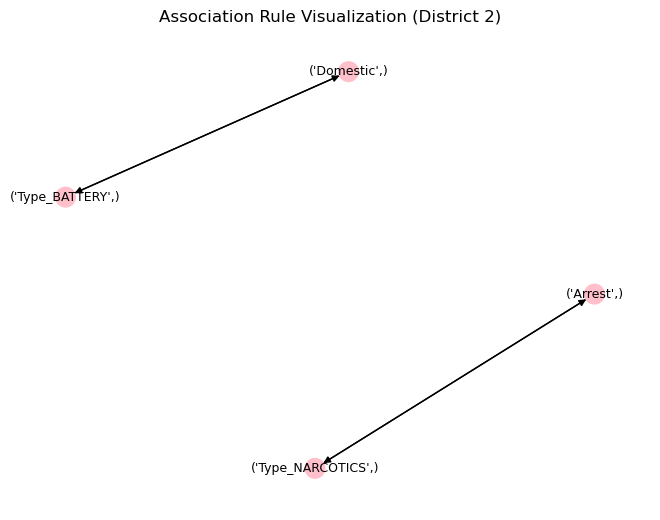

District  3
            antecedents           consequents  antecedent support  \
0        (Type_BATTERY)  (Location_APARTMENT)            0.220835   
1  (Location_APARTMENT)        (Type_BATTERY)            0.251688   
2        (Type_BATTERY)            (Domestic)            0.220835   
3            (Domestic)        (Type_BATTERY)            0.241565   
4              (Arrest)      (Type_NARCOTICS)            0.252537   
5      (Type_NARCOTICS)              (Arrest)            0.086896   
6            (Domestic)  (Location_APARTMENT)            0.241565   
7  (Location_APARTMENT)            (Domestic)            0.251688   

   consequent support   support  confidence      lift  leverage  conviction  \
0            0.251688  0.087444    0.395971  1.573259  0.031863    1.238867   
1            0.220835  0.087444    0.347430  1.573259  0.031863    1.193995   
2            0.241565  0.135482    0.613501  2.539697  0.082136    1.962322   
3            0.220835  0.135482    0.560853  2.539

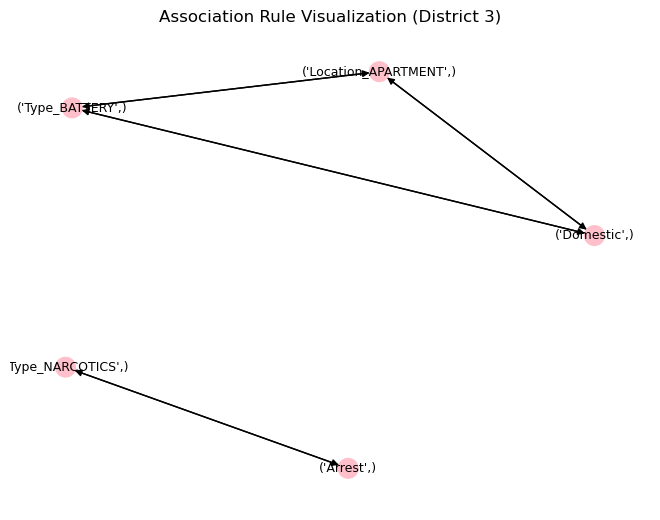

District  4
            antecedents           consequents  antecedent support  \
0        (Type_BATTERY)            (Domestic)            0.207272   
1            (Domestic)        (Type_BATTERY)            0.220901   
2            (Domestic)  (Location_RESIDENCE)            0.220901   
3  (Location_RESIDENCE)            (Domestic)            0.240758   

   consequent support   support  confidence      lift  leverage  conviction  \
0            0.220901  0.120515    0.581436  2.632104  0.074728    1.861359   
1            0.207272  0.120515    0.545560  2.632104  0.074728    1.744409   
2            0.240758  0.098773    0.447135  1.857203  0.045589    1.373289   
3            0.220901  0.098773    0.410259  1.857203  0.045589    1.321085   

   zhangs_metric  
0       0.782205  
1       0.795889  
2       0.592423  
3       0.607916  


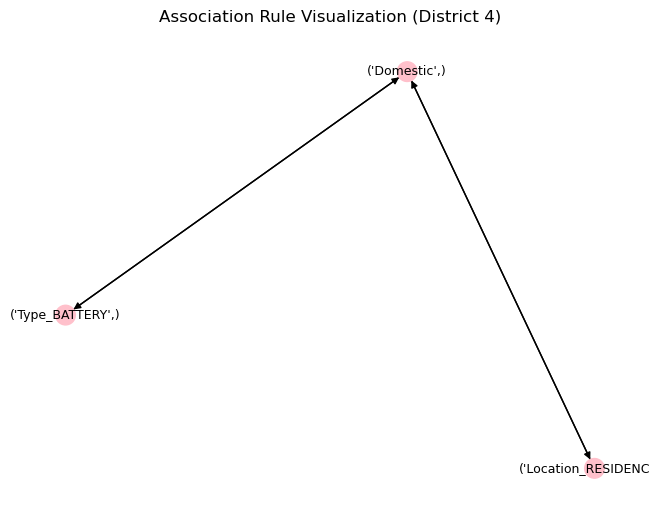

District  5
            antecedents           consequents  antecedent support  \
0        (Type_BATTERY)  (Location_RESIDENCE)            0.226004   
1  (Location_RESIDENCE)        (Type_BATTERY)            0.300203   
2        (Type_BATTERY)            (Domestic)            0.226004   
3            (Domestic)        (Type_BATTERY)            0.238106   
4              (Arrest)      (Type_NARCOTICS)            0.250400   
5      (Type_NARCOTICS)              (Arrest)            0.092703   
6            (Domestic)  (Location_RESIDENCE)            0.238106   
7  (Location_RESIDENCE)            (Domestic)            0.300203   
8     (Location_STREET)              (Arrest)            0.263972   
9              (Arrest)     (Location_STREET)            0.250400   

   consequent support   support  confidence      lift  leverage  conviction  \
0            0.300203  0.081882    0.362303  1.206859  0.014035    1.097381   
1            0.226004  0.081882    0.272755  1.206859  0.014035    1.0

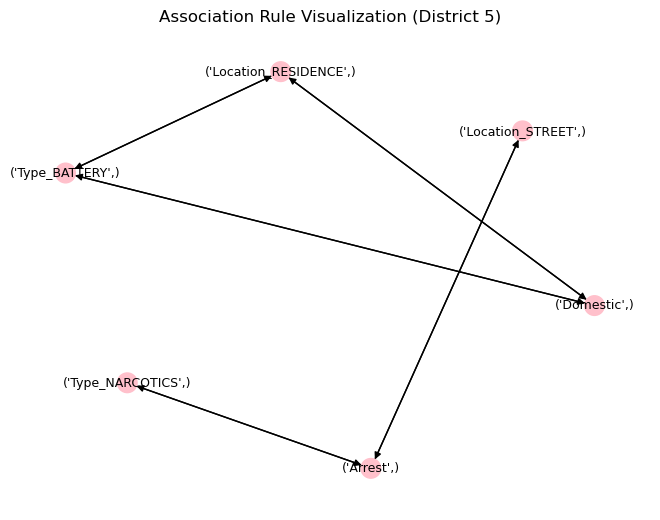

District  6
            antecedents           consequents  antecedent support  \
0        (Type_BATTERY)            (Domestic)            0.204795   
1            (Domestic)        (Type_BATTERY)            0.228529   
2              (Arrest)      (Type_NARCOTICS)            0.255811   
3      (Type_NARCOTICS)              (Arrest)            0.086703   
4            (Domestic)  (Location_RESIDENCE)            0.228529   
5  (Location_RESIDENCE)            (Domestic)            0.198569   

   consequent support   support  confidence      lift  leverage  conviction  \
0            0.228529  0.125263    0.611653  2.676475  0.078462    1.986550   
1            0.204795  0.125263    0.548128  2.676475  0.078462    1.759801   
2            0.086703  0.086316    0.337423  3.891734  0.064137    1.378403   
3            0.255811  0.086316    0.995547  3.891734  0.064137  167.112335   
4            0.198569  0.084373    0.369199  1.859298  0.038994    1.270498   
5            0.228529  0.08437

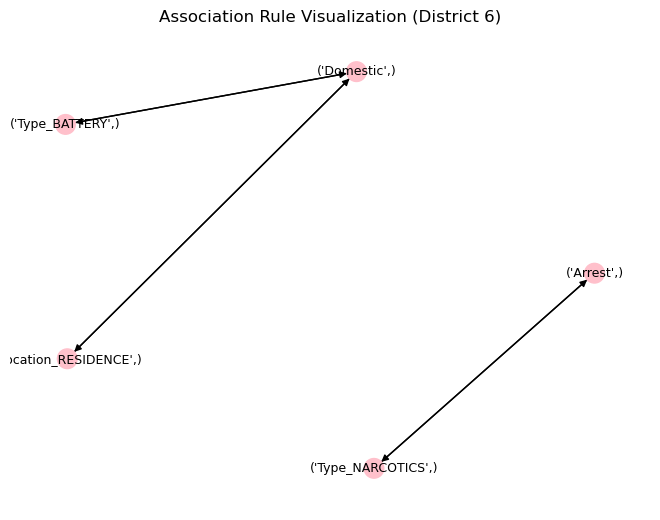

District  7
            antecedents           consequents  antecedent support  \
0        (Type_BATTERY)            (Domestic)            0.245329   
1            (Domestic)        (Type_BATTERY)            0.236963   
2              (Arrest)      (Type_NARCOTICS)            0.278044   
3      (Type_NARCOTICS)              (Arrest)            0.113809   
4            (Domestic)  (Location_RESIDENCE)            0.236963   
5  (Location_RESIDENCE)            (Domestic)            0.226481   
6     (Location_STREET)              (Arrest)            0.272474   
7              (Arrest)     (Location_STREET)            0.278044   

   consequent support   support  confidence      lift  leverage  conviction  \
0            0.236963  0.140675    0.573415  2.419853  0.082541    1.788712   
1            0.245329  0.140675    0.593659  2.419853  0.082541    1.857239   
2            0.113809  0.113589    0.408529  3.589599  0.081945    1.498283   
3            0.278044  0.113589    0.998067  3.589

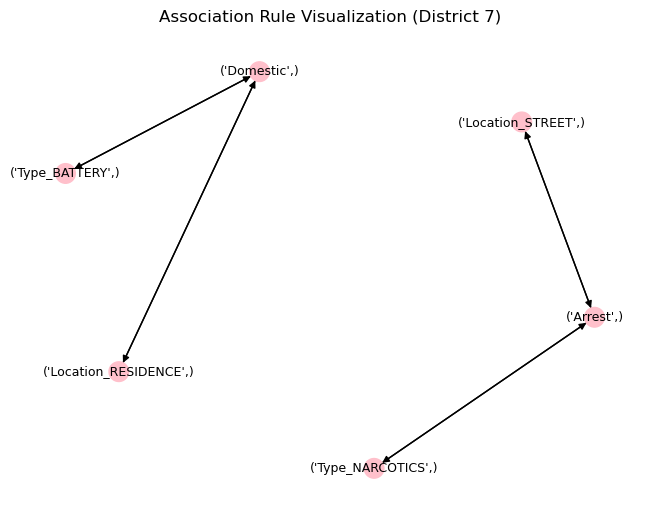

District  8
            antecedents           consequents  antecedent support  \
0        (Type_BATTERY)            (Domestic)            0.167411   
1            (Domestic)        (Type_BATTERY)            0.171928   
2            (Domestic)  (Location_RESIDENCE)            0.171928   
3  (Location_RESIDENCE)            (Domestic)            0.231752   

   consequent support   support  confidence      lift  leverage  conviction  \
0            0.171928  0.093690    0.559639  3.255080  0.064907    1.880439   
1            0.167411  0.093690    0.544935  3.255080  0.064907    1.829606   
2            0.231752  0.090081    0.523945  2.260801  0.050236    1.613780   
3            0.171928  0.090081    0.388695  2.260801  0.050236    1.354597   

   zhangs_metric  
0       0.832088  
1       0.836627  
2       0.673467  
3       0.725910  


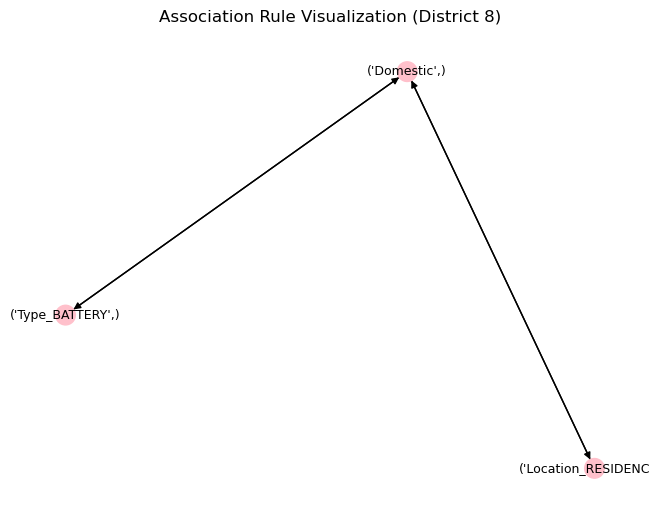

District  9
         antecedents        consequents  antecedent support  \
0     (Type_BATTERY)         (Domestic)            0.189620   
1         (Domestic)     (Type_BATTERY)            0.168738   
2           (Arrest)   (Type_NARCOTICS)            0.274671   
3   (Type_NARCOTICS)           (Arrest)            0.090977   
4  (Location_STREET)           (Arrest)            0.304565   
5           (Arrest)  (Location_STREET)            0.274671   
6  (Location_STREET)       (Time_Night)            0.304565   
7       (Time_Night)  (Location_STREET)            0.219763   

   consequent support   support  confidence      lift  leverage  conviction  \
0            0.168738  0.099726    0.525929  3.116842  0.067730    1.753454   
1            0.189620  0.099726    0.591015  3.116842  0.067730    1.981441   
2            0.090977  0.090696    0.330199  3.629497  0.065707    1.357155   
3            0.274671  0.090696    0.996916  3.629497  0.065707  235.188084   
4            0.274671  0.

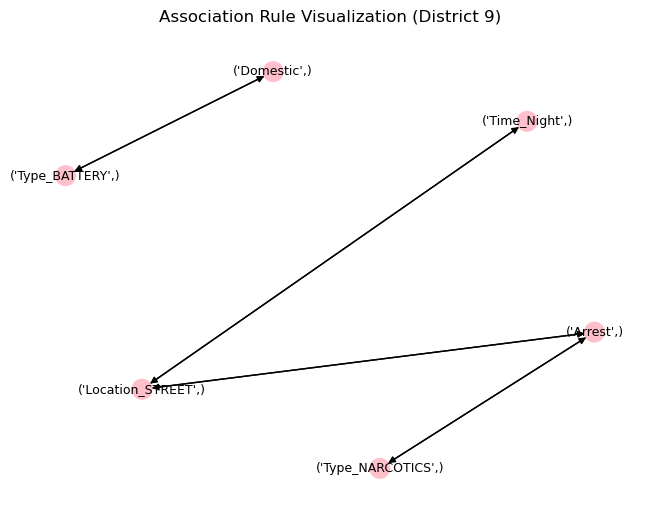

District  10
           antecedents          consequents  antecedent support  \
0       (Type_BATTERY)           (Domestic)            0.218073   
1           (Domestic)       (Type_BATTERY)            0.200494   
2             (Arrest)     (Type_NARCOTICS)            0.313017   
3     (Type_NARCOTICS)             (Arrest)            0.138347   
4             (Arrest)  (Location_SIDEWALK)            0.313017   
5  (Location_SIDEWALK)             (Arrest)            0.152284   
8             (Arrest)         (Time_Night)            0.313017   
9         (Time_Night)             (Arrest)            0.222444   

   consequent support   support  confidence      lift  leverage  conviction  \
0            0.200494  0.119393    0.547493  2.730720  0.075671    1.766836   
1            0.218073  0.119393    0.595496  2.730720  0.075671    1.933051   
2            0.138347  0.137308    0.438659  3.170721  0.094003    1.534991   
3            0.313017  0.137308    0.992489  3.170721  0.094003   9

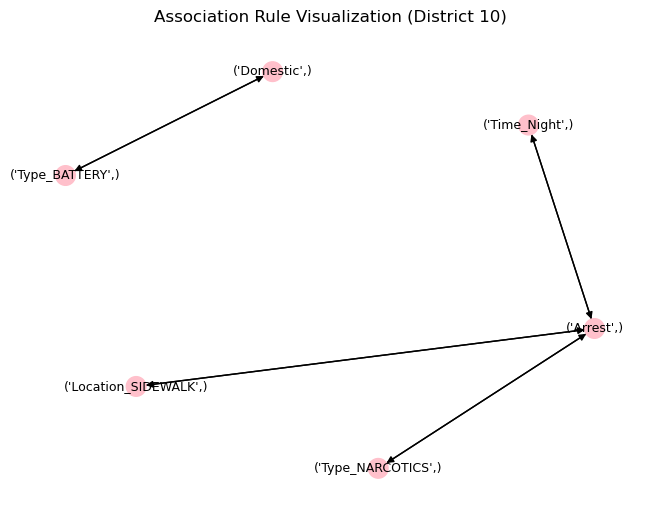

District  11
                            antecedents                          consequents  \
0                        (Type_BATTERY)                           (Domestic)   
1                            (Domestic)                       (Type_BATTERY)   
2                   (Location_SIDEWALK)                     (Type_NARCOTICS)   
3                      (Type_NARCOTICS)                  (Location_SIDEWALK)   
4                     (Location_STREET)                     (Type_NARCOTICS)   
5                      (Type_NARCOTICS)                    (Location_STREET)   
6                              (Arrest)                     (Type_NARCOTICS)   
7                      (Type_NARCOTICS)                             (Arrest)   
8                              (Arrest)                  (Location_SIDEWALK)   
9                   (Location_SIDEWALK)                             (Arrest)   
10                    (Location_STREET)                             (Arrest)   
11                         

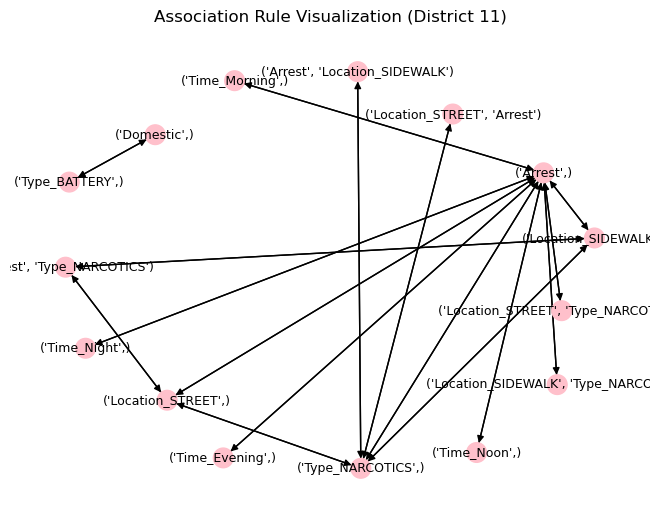

District  12
         antecedents        consequents  antecedent support  \
0  (Location_STREET)       (Type_THEFT)            0.322712   
1       (Type_THEFT)  (Location_STREET)            0.286771   
2  (Location_STREET)       (Time_Night)            0.322712   
3       (Time_Night)  (Location_STREET)            0.210359   

   consequent support   support  confidence      lift  leverage  conviction  \
0            0.286771  0.116055    0.359623  1.254041  0.023510    1.113764   
1            0.322712  0.116055    0.404694  1.254041  0.023510    1.137715   
2            0.210359  0.083123    0.257575  1.224454  0.015237    1.063597   
3            0.322712  0.083123    0.395146  1.224454  0.015237    1.119755   

   zhangs_metric  
0       0.299102  
1       0.284030  
2       0.270652  
3       0.232143  


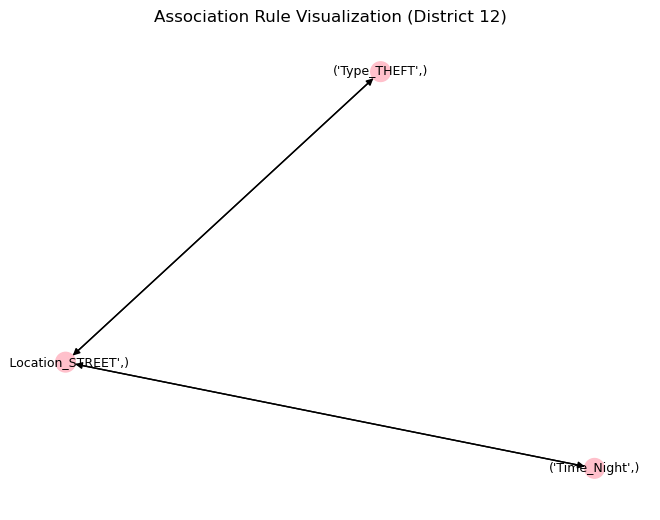

District  14
         antecedents        consequents  antecedent support  \
0  (Location_STREET)       (Type_THEFT)            0.307580   
1       (Type_THEFT)  (Location_STREET)            0.288759   
2  (Location_STREET)       (Time_Night)            0.307580   
3       (Time_Night)  (Location_STREET)            0.221075   

   consequent support   support  confidence      lift  leverage  conviction  \
0            0.288759  0.108217    0.351832  1.218428  0.019400    1.097310   
1            0.307580  0.108217    0.374764  1.218428  0.019400    1.107454   
2            0.221075  0.088673    0.288293  1.304050  0.020675    1.094446   
3            0.307580  0.088673    0.401100  1.304050  0.020675    1.156152   

   zhangs_metric  
0       0.258904  
1       0.252053  
2       0.336730  
3       0.299334  


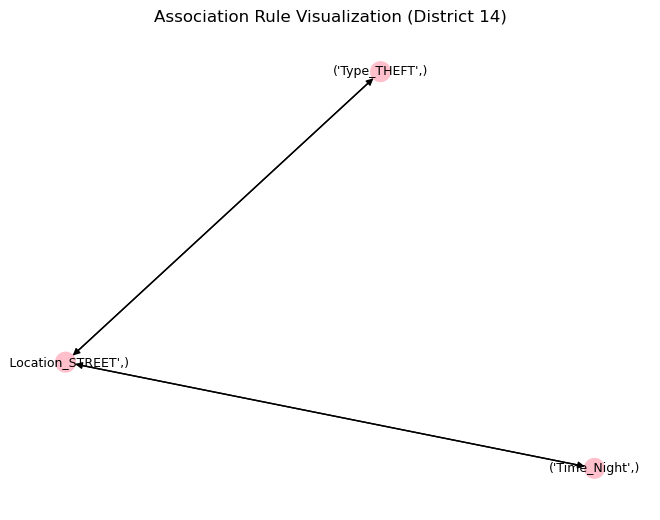

District  15
                            antecedents                          consequents  \
0                        (Type_BATTERY)                           (Domestic)   
1                            (Domestic)                       (Type_BATTERY)   
2                   (Location_SIDEWALK)                     (Type_NARCOTICS)   
3                      (Type_NARCOTICS)                  (Location_SIDEWALK)   
4                              (Arrest)                     (Type_NARCOTICS)   
5                      (Type_NARCOTICS)                             (Arrest)   
6                            (Domestic)                 (Location_APARTMENT)   
7                  (Location_APARTMENT)                           (Domestic)   
8                              (Arrest)                  (Location_SIDEWALK)   
9                   (Location_SIDEWALK)                             (Arrest)   
10                    (Location_STREET)                             (Arrest)   
11                         

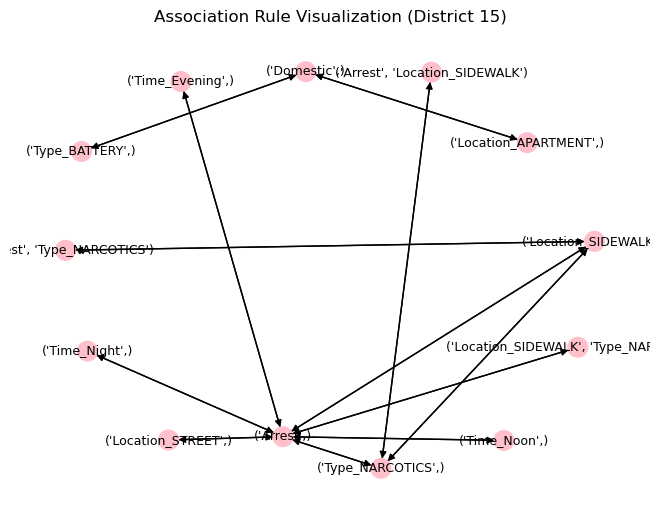

District  16
            antecedents           consequents  antecedent support  \
0            (Domestic)  (Location_RESIDENCE)            0.146415   
1  (Location_RESIDENCE)            (Domestic)            0.231420   

   consequent support   support  confidence     lift  leverage  conviction  \
0            0.231420  0.082693    0.564787  2.44053   0.04881    1.765985   
1            0.146415  0.082693    0.357331  2.44053   0.04881    1.328187   

   zhangs_metric  
0       0.691499  
1       0.767978  


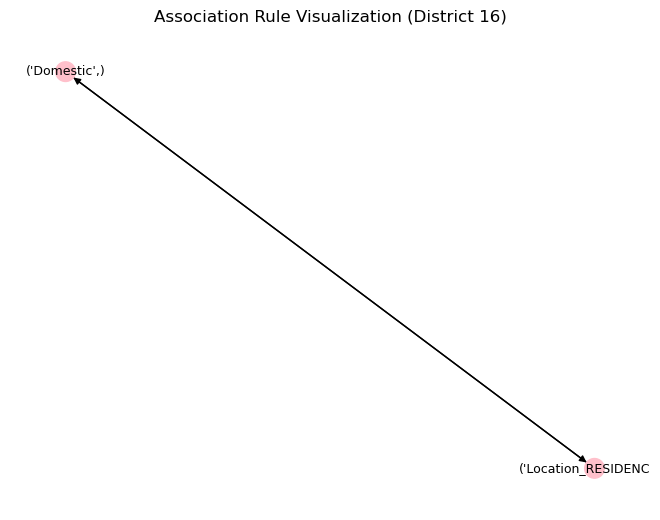

District  17
         antecedents        consequents  antecedent support  \
0     (Type_BATTERY)         (Domestic)            0.157513   
1         (Domestic)     (Type_BATTERY)            0.141329   
2  (Location_STREET)       (Time_Night)            0.272609   
3       (Time_Night)  (Location_STREET)            0.218846   

   consequent support   support  confidence      lift  leverage  conviction  \
0            0.141329  0.080331    0.509996  3.608564  0.058070    1.752373   
1            0.157513  0.080331    0.568397  3.608564  0.058070    1.951994   
2            0.218846  0.081558    0.299176  1.367062  0.021899    1.114622   
3            0.272609  0.081558    0.372674  1.367062  0.021899    1.159510   

   zhangs_metric  
0       0.858033  
1       0.841861  
2       0.369134  
3       0.343728  


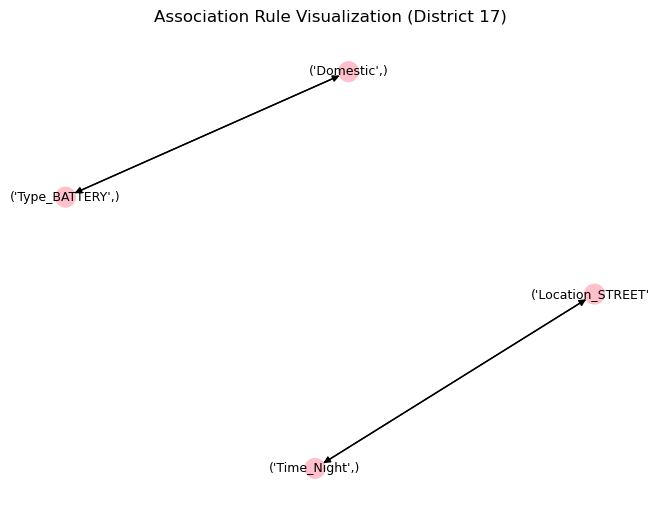

District  18
      antecedents     consequents  antecedent support  consequent support  \
2     (Beat_1834)    (Type_THEFT)            0.160123            0.420890   
3    (Type_THEFT)     (Beat_1834)            0.420890            0.160123   
4  (Time_Evening)    (Type_THEFT)            0.227317            0.420890   
5    (Type_THEFT)  (Time_Evening)            0.420890            0.227317   
6     (Time_Noon)    (Type_THEFT)            0.213867            0.420890   
7    (Type_THEFT)     (Time_Noon)            0.420890            0.213867   

    support  confidence      lift  leverage  conviction  zhangs_metric  
2  0.082999    0.518346  1.231547  0.015605    1.202336       0.223858  
3  0.082999    0.197199  1.231547  0.015605    1.046183       0.324659  
4  0.114306    0.502848  1.194726  0.018631    1.164856       0.210938  
5  0.114306    0.271582  1.194726  0.018631    1.060768       0.281446  
6  0.109519    0.512090  1.216683  0.019505    1.186919       0.226544  
7  0.1095

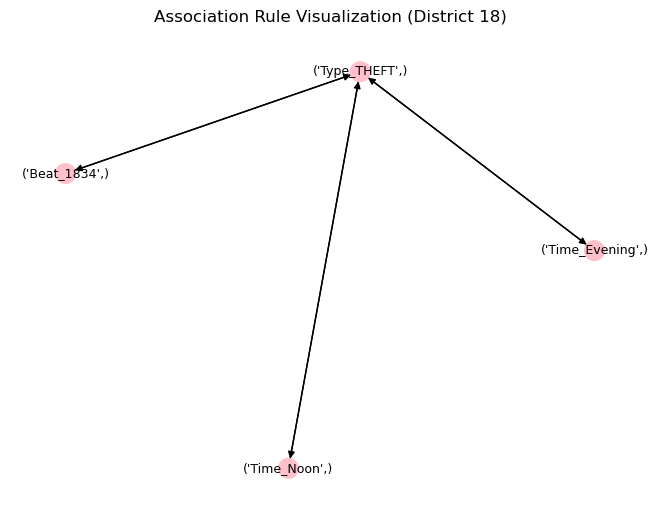

District  19
         antecedents        consequents  antecedent support  \
0  (Location_STREET)       (Type_THEFT)            0.240951   
1       (Type_THEFT)  (Location_STREET)            0.339897   
2     (Time_Evening)       (Type_THEFT)            0.214559   
3       (Type_THEFT)     (Time_Evening)            0.339897   

   consequent support   support  confidence      lift  leverage  conviction  \
0            0.339897  0.096769    0.401614  1.181576  0.014871    1.103139   
1            0.240951  0.096769    0.284702  1.181576  0.014871    1.061165   
2            0.339897  0.084882    0.395609  1.163911  0.011954    1.092180   
3            0.214559  0.084882    0.249728  1.163911  0.011954    1.046874   

   zhangs_metric  
0       0.202455  
1       0.232801  
2       0.179297  
3       0.213342  


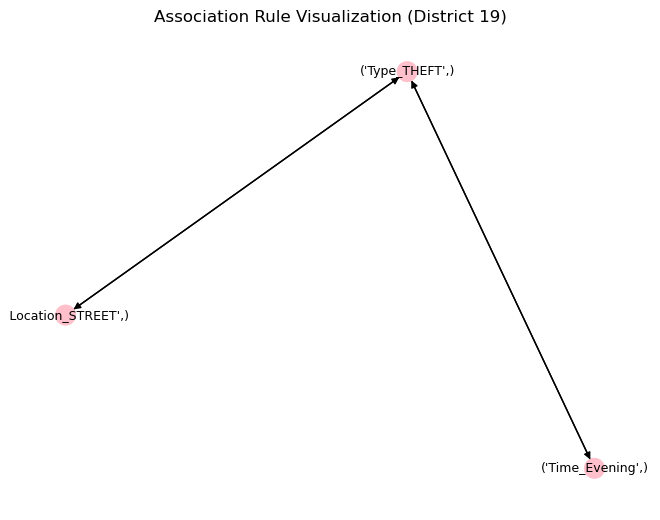

District  20
Empty DataFrame
Columns: [antecedents, consequents, antecedent support, consequent support, support, confidence, lift, leverage, conviction, zhangs_metric]
Index: []


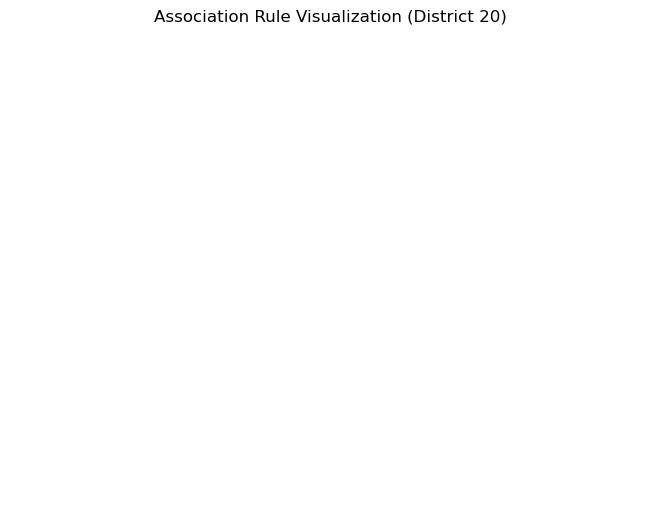

District  22
            antecedents           consequents  antecedent support  \
0        (Type_BATTERY)            (Domestic)            0.176838   
1            (Domestic)        (Type_BATTERY)            0.195767   
2            (Domestic)  (Location_RESIDENCE)            0.195767   
3  (Location_RESIDENCE)            (Domestic)            0.308427   

   consequent support   support  confidence      lift  leverage  conviction  \
0            0.195767  0.096060    0.543209  2.774774  0.061441    1.760615   
1            0.176838  0.096060    0.490685  2.774774  0.061441    1.616215   
2            0.308427  0.123837    0.632575  2.050974  0.063458    1.882217   
3            0.195767  0.123837    0.401513  2.050974  0.063458    1.343777   

   zhangs_metric  
0       0.777016  
1       0.795305  
2       0.637162  
3       0.740958  


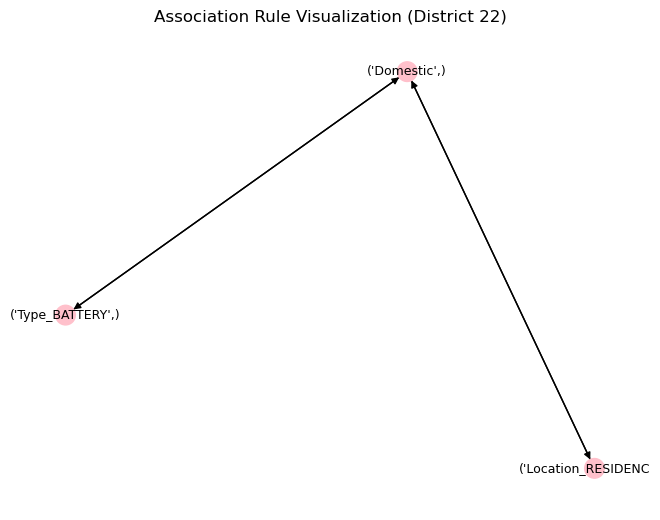

District  24
      antecedents     consequents  antecedent support  consequent support  \
0  (Type_BATTERY)      (Domestic)            0.171895            0.148098   
1      (Domestic)  (Type_BATTERY)            0.148098            0.171895   

    support  confidence      lift  leverage  conviction  zhangs_metric  
0  0.086535    0.503415  3.399211  0.061077    1.715523       0.852325  
1  0.086535    0.584308  3.399211  0.061077    1.992111       0.828515  


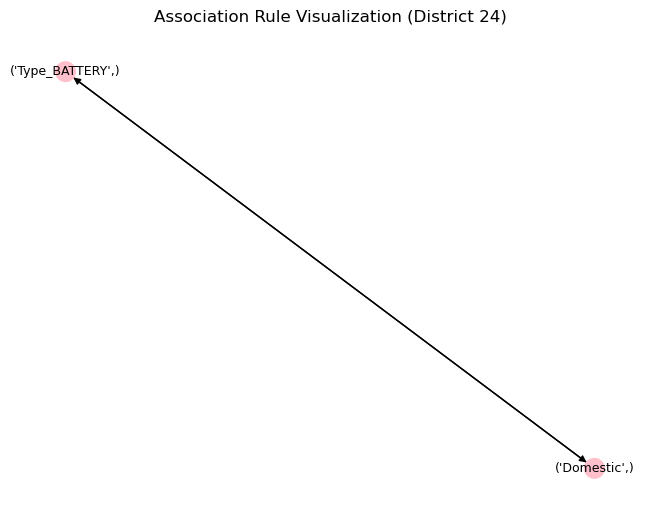

District  25
         antecedents        consequents  antecedent support  \
0     (Type_BATTERY)         (Domestic)            0.177647   
1         (Domestic)     (Type_BATTERY)            0.179517   
2           (Arrest)   (Type_NARCOTICS)            0.268371   
3   (Type_NARCOTICS)           (Arrest)            0.087801   
4  (Location_STREET)           (Arrest)            0.278937   
5           (Arrest)  (Location_STREET)            0.268371   

   consequent support   support  confidence      lift  leverage  conviction  \
0            0.179517  0.101667    0.572301  3.188010  0.069777    1.918365   
1            0.177647  0.101667    0.566339  3.188010  0.069777    1.896306   
2            0.087801  0.087567    0.326291  3.716239  0.064004    1.353995   
3            0.268371  0.087567    0.997332  3.716239  0.064004  274.172681   
4            0.268371  0.084021    0.301220  1.122401  0.009163    1.047009   
5            0.278937  0.084021    0.313079  1.122401  0.009163    1.04

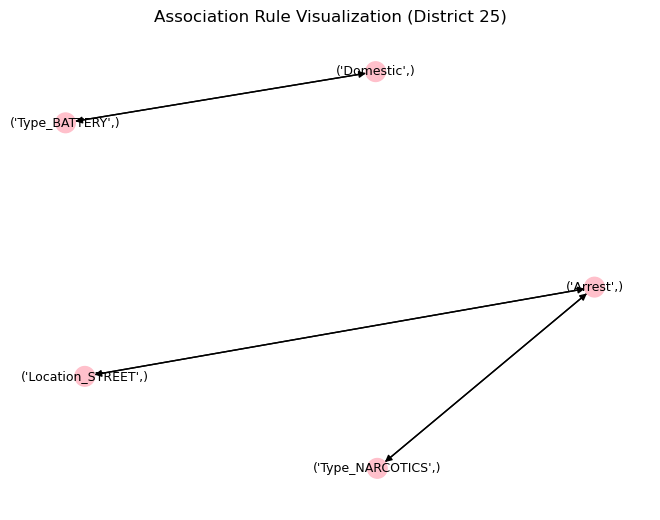

In [26]:
# Run through all values of district and subset the data
# One hot encode to use with Apriori algorithm
# Get frequent itemsets
# Generate strong rules
# Plot directed graph

for i in [1,2,3,4,5,6,7,8,9,10,11,12,14,15,16,17,18,19,20,22,24,25]:
    df_tmp = df.loc[df["District"] == i]
    if not df_tmp.empty:
        df_tmp_onehot_type = pd.get_dummies(df_tmp['Primary Type'], prefix='Type')
        df_tmp_onehot_description = pd.get_dummies(df_tmp['Description'], prefix='Description')
        df_tmp_onehot_location = pd.get_dummies(df_tmp['Location Description'], prefix='Location')
        df_tmp_onehot_domestic = df_tmp['Domestic']
        df_tmp_onehot_arrest = df_tmp['Arrest']
        # df_tmp_onehot_month = pd.get_dummies(df_tmp['Month'], prefix='Month')
        # df_tmp_onehot_day = pd.get_dummies(df_tmp['Day'], prefix='Day')
        df_tmp_onehot_time = pd.get_dummies(df_tmp['Time'], prefix="Time")
        df_tmp_onehot_beat = pd.get_dummies(df_tmp['Beat'], prefix='Beat')
        df_tmp_onehot = pd.concat([df_tmp_onehot_type,df_tmp_onehot_location,df_tmp_onehot_domestic,df_tmp_onehot_arrest,df_tmp_onehot_beat, df_tmp_onehot_time], axis=1)
        print("District ", i)
        freq_items_tmp = apriori(df_tmp_onehot, min_support=0.08, use_colnames=True)
        rules_tmp = association_rules(freq_items_tmp, metric="confidence", min_threshold=0.07)

        # Remove rules with a lift less than or equal to 1
        idx_rules_tmp = rules_tmp.index[rules_tmp['lift'] <=1 ].tolist()
        rules_tmp = rules_tmp.drop(idx_rules_tmp)

        print(rules_tmp)
        
        # Create a directed graph
        G = nx.DiGraph()

        # Add nodes
        for item in rules_tmp['antecedents']:
            G.add_node(tuple(item), shape='ellipse', style='filled', fillcolor='lightblue')
        for item in rules_tmp['consequents']:
            G.add_node(tuple(item), shape='ellipse', style='filled', fillcolor='pink')

        # Add edges
        for idx, row in rules_tmp.iterrows():
            G.add_edge(tuple(row['antecedents']), tuple(row['consequents']))

        # Plot the graph
        pos = nx.spring_layout(G, k=4,seed=7)
        edge_labels = nx.get_edge_attributes(G, 'label')
        nx.draw(G, pos, with_labels=True, node_size=200, font_size=9, node_color=['lightblue' if 'antecedents' in node else 'pink' for node in G.nodes()])
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7)
        plt.title("Association Rule Visualization (District "+ str(i) + ")")
        plt.show();
        


Districts which need further customization to produce list of association rules below.

## Classification

### Predict if arrest was made using Decision Tree algorithm with entire dataset

In [27]:
# One hot encode to use with Decision Tree algorithm
df_onehot_dt_type = pd.get_dummies(df['Primary Type'], prefix='Type', dtype=np.int8)
df_onehot_dt_location = pd.get_dummies(df['Location Description'], prefix='Location', dtype=np.int8)
df_onehot_dt_district = pd.get_dummies(df['District'], prefix='District', dtype=np.int8)
df_onehot_dt_domestic = df['Domestic'].astype(np.int8)
df_onehot_dt_day = pd.get_dummies(df['Day'], dtype=np.int8, prefix='Day')
df_onehot_dt_time = pd.get_dummies(df['Time'], dtype=np.int8,prefix="Time")
df_onehot_dt = pd.concat([df_onehot_dt_type,df_onehot_dt_location, df_onehot_dt_district,df_onehot_dt_domestic,df_onehot_dt_day,df_onehot_dt_time, df['Arrest'].astype(np.int8)], axis=1)
print(df_onehot_dt)

         Type_ARSON  Type_ASSAULT  Type_BATTERY  Type_BURGLARY  \
0                 0             1             0              0   
1                 0             0             0              0   
2                 0             0             0              0   
3                 0             0             0              0   
4                 0             0             0              0   
...             ...           ...           ...            ...   
7891850           0             0             0              0   
7891851           0             0             0              0   
7891852           0             0             0              0   
7891853           0             0             0              0   
7891854           0             0             0              0   

         Type_CONCEALED CARRY LICENSE VIOLATION  Type_CRIM SEXUAL ASSAULT  \
0                                             0                         0   
1                                             0      

#### Decision Tree algorithm results

In [28]:
# Split dataset in features and target variable
df_onehot_dt.columns = df_onehot_dt.columns.astype(str)
feature_cols_dt = df_onehot_dt.columns[0:312] # Features
X = df_onehot_dt[feature_cols_dt]
y = df_onehot_dt.Arrest # Target variable

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # 70% training and 30% test

# Create Decision Tree classifer object
clf = DecisionTreeClassifier(criterion="entropy",max_depth=15)

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

# Predict the response for test dataset
y_pred = clf.predict(X_test)

# Model Accuracy
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.8758745991861046


#### Confusion matrix and classification report

In [29]:
# Print confusion matrix and classification report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[1695876   54506]
 [ 238919  374639]]
              precision    recall  f1-score   support

           0       0.88      0.97      0.92   1750382
           1       0.87      0.61      0.72    613558

    accuracy                           0.88   2363940
   macro avg       0.87      0.79      0.82   2363940
weighted avg       0.88      0.88      0.87   2363940



Note F1 score is high for negative class but signficantly lower for positve class.

#### Plot Features Importances

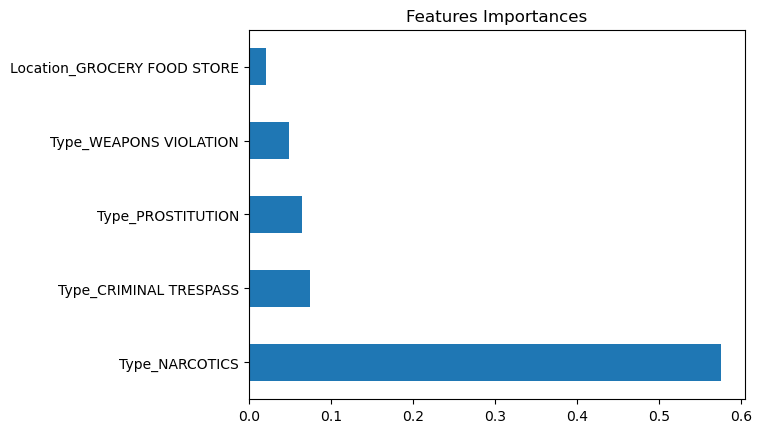

In [30]:
# Plot most important features
feat_importances = pd.Series(clf.feature_importances_, index=feature_cols_dt)
feat_importances.nlargest(5).plot(kind='barh', title="Features Importances");

The feature of Primary Type with value of Narcotics dominates prediction of arrest with values in order of importance:
* Primary Type - Narcotics
* Primary Type - Criminal Trespass
* Primary Type - Prostitution
* Primary Type - Weapons Violation
* Location Description - Grocery Food Store

Our dataset is imbalanced where approximately 26% of objects have Arrest as value true (1). We'll first try oversampling to see if we can improve the model.

In [31]:
# Positive class only occurs approximately 26% of the time
len(df[df['Arrest'] == True]) / len(df)

0.25983166065932145

### Repeat Decision Tree algorithm with balanced dataset (oversampling)

In [32]:
# One hot encode to use with Decision Tree algorithm
df_onehot_dt_type = pd.get_dummies(df['Primary Type'], prefix='Type', dtype=np.int8)
df_onehot_dt_location = pd.get_dummies(df['Location Description'], prefix='Location', dtype=np.int8)
df_onehot_dt_district = pd.get_dummies(df['District'], prefix='District', dtype=np.int8)
df_onehot_dt_domestic = df['Domestic'].astype(np.int8)
df_onehot_dt_day = pd.get_dummies(df['Day'], dtype=np.int8, prefix='Day')
df_onehot_dt_time = pd.get_dummies(df['Time'], dtype=np.int8,prefix="Time")
df_onehot_dt = pd.concat([df_onehot_dt_type,df_onehot_dt_location, df_onehot_dt_district,df_onehot_dt_domestic,df_onehot_dt_day,df_onehot_dt_time, df['Arrest'].astype(np.int8)], axis=1)
print(df_onehot_dt)

         Type_ARSON  Type_ASSAULT  Type_BATTERY  Type_BURGLARY  \
0                 0             1             0              0   
1                 0             0             0              0   
2                 0             0             0              0   
3                 0             0             0              0   
4                 0             0             0              0   
...             ...           ...           ...            ...   
7891850           0             0             0              0   
7891851           0             0             0              0   
7891852           0             0             0              0   
7891853           0             0             0              0   
7891854           0             0             0              0   

         Type_CONCEALED CARRY LICENSE VIOLATION  Type_CRIM SEXUAL ASSAULT  \
0                                             0                         0   
1                                             0      

In [33]:
# Split dataset in features and target variable
df_onehot_dt.columns = df_onehot_dt.columns.astype(str)
feature_cols_dt = df_onehot_dt.columns[0:312] # Features
X = df_onehot_dt[feature_cols_dt]
y = df_onehot_dt.Arrest # Target variable

ros = RandomOverSampler( # Oversampling
    sampling_strategy='auto',
    random_state=1,
)  
X, y = ros.fit_resample(X, y)

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # 70% training and 30% test

# Create Decision Tree classifer object
clf = DecisionTreeClassifier(criterion="entropy",max_depth=15)

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

# Predict the response for test dataset
y_pred = clf.predict(X_test)

# Model Accuracy
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7877509660867337


#### Confusion matrix and classification report

In [34]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[1631560  117469]
 [ 625281 1125117]]
              precision    recall  f1-score   support

           0       0.72      0.93      0.81   1749029
           1       0.91      0.64      0.75   1750398

    accuracy                           0.79   3499427
   macro avg       0.81      0.79      0.78   3499427
weighted avg       0.81      0.79      0.78   3499427



F1 score has improved for class 1, class 0 F1 score has decreased.

#### Plot Features Importances

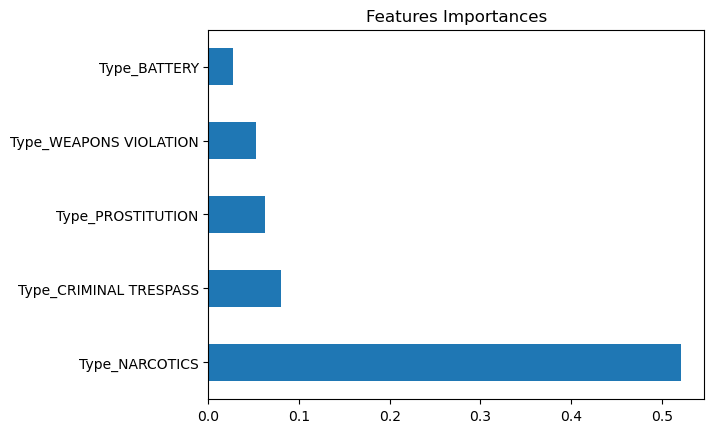

In [35]:
feat_importances = pd.Series(clf.feature_importances_, index=feature_cols_dt)
feat_importances.nlargest(5).plot(kind='barh', title="Features Importances");

The feature of Primary Type with value of Narcotics dominates prediction of arrest with values in order of importance:
* Primary Type - Narcotics
* Primary Type - Criminal Trespass
* Primary Type - Prostitution
* Primary Type - Weapons Violation
* Location Description - Grocery Food Store

We'll next try undersampling and compare to the oversampling model.

### Repeat Decision Tree algorithm with balanced dataset (undersampling)

In [36]:
# Undersample by using random sample. Print values for true and false values.
df_balanced = df.groupby('Arrest').sample(n=2047400,random_state=1)
df_balanced.Arrest.value_counts()

Arrest
False    2047400
True     2047400
Name: count, dtype: int64

In [37]:
# One hot encode to use with Decision Tree algorithm
df_onehot_dt_type = pd.get_dummies(df_balanced['Primary Type'], prefix='Type', dtype=np.int8)
df_onehot_dt_location = pd.get_dummies(df_balanced['Location Description'], prefix='Location', dtype=np.int8)
df_onehot_dt_district = pd.get_dummies(df_balanced['District'], prefix='District', dtype=np.int8)
df_onehot_dt_domestic = df_balanced['Domestic'].astype(np.int8)
df_onehot_dt_day = pd.get_dummies(df_balanced['Day'], dtype=np.int8, prefix='Day')
df_onehot_dt_time = pd.get_dummies(df_balanced['Time'], dtype=np.int8,prefix="Time")
df_onehot_dt = pd.concat([df_onehot_dt_type,df_onehot_dt_location,df_onehot_dt_district,df_onehot_dt_domestic,df_onehot_dt_day, df_onehot_dt_time, df_balanced['Arrest'].astype(np.int8)], axis=1)
print(df_onehot_dt)

         Type_ARSON  Type_ASSAULT  Type_BATTERY  Type_BURGLARY  \
1419861           0             0             0              0   
1380340           0             1             0              0   
3438365           0             0             1              0   
5647606           0             0             0              0   
2636240           0             0             0              0   
...             ...           ...           ...            ...   
2763179           0             0             0              0   
4895189           0             0             0              0   
3291316           0             0             0              0   
4977509           0             0             0              0   
3414082           0             0             0              0   

         Type_CONCEALED CARRY LICENSE VIOLATION  Type_CRIM SEXUAL ASSAULT  \
1419861                                       0                         0   
1380340                                       0      

In [38]:
# Split dataset in features and target variable
df_onehot_dt.columns = df_onehot_dt.columns.astype(str)
feature_cols_dt = df_onehot_dt.columns[0:312] # Features
X = df_onehot_dt[feature_cols_dt]
y = df_onehot_dt.Arrest # Target variable

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1) # 80% training and 20% test

# Create Decision Tree classifer object
clf = DecisionTreeClassifier(criterion="entropy",max_depth=15)

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

# Predict the response for test dataset
y_pred = clf.predict(X_test)

# Model Accuracy
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7874621471134121


#### Confusion matrix and classification report

In [39]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[384694  25157]
 [148903 260206]]
              precision    recall  f1-score   support

           0       0.72      0.94      0.82    409851
           1       0.91      0.64      0.75    409109

    accuracy                           0.79    818960
   macro avg       0.82      0.79      0.78    818960
weighted avg       0.82      0.79      0.78    818960



The scores for precision, recall, and F1 are almost identical to the oversampling model.

#### Plot Features Importances

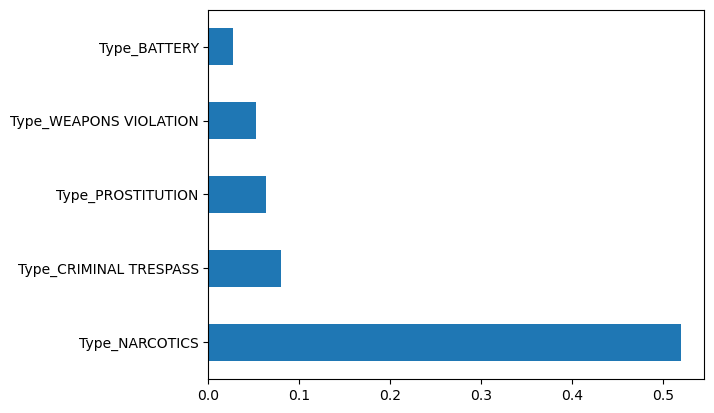

In [40]:
feat_importances = pd.Series(clf.feature_importances_, index=feature_cols_dt)
feat_importances.nlargest(5).plot(kind='barh');

The feature of Primary Type with value of Narcotics dominates prediction of arrest with features in order of importance:
* Primary Type - Narcotics
* Primary Type - Criminal Trespass
* Primary Type - Prostitution
* Primary Type - Weapons Violation
* Primary Type - Battery

As the oversampling and undersampling models were approximately equivalent, I will use undersampling to reduce the amount of time to process the data.

### Decision Tree algorithm applied to each district
Using balanced dataset (undersampling), apply Decision Tree algorithm. Display confusion matrix, classification report, and plot feature importances.

District  1
Accuracy: 0.7913615747191178
[[13875  2730]
 [ 4308 12820]]
              precision    recall  f1-score   support

           0       0.76      0.84      0.80     16605
           1       0.82      0.75      0.78     17128

    accuracy                           0.79     33733
   macro avg       0.79      0.79      0.79     33733
weighted avg       0.79      0.79      0.79     33733



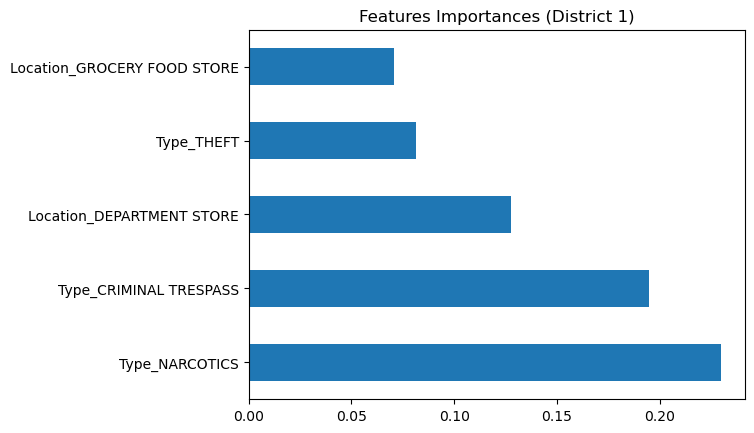

District  2
Accuracy: 0.7924849673539962
[[18606   905]
 [ 7136 12102]]
              precision    recall  f1-score   support

           0       0.72      0.95      0.82     19511
           1       0.93      0.63      0.75     19238

    accuracy                           0.79     38749
   macro avg       0.83      0.79      0.79     38749
weighted avg       0.83      0.79      0.79     38749



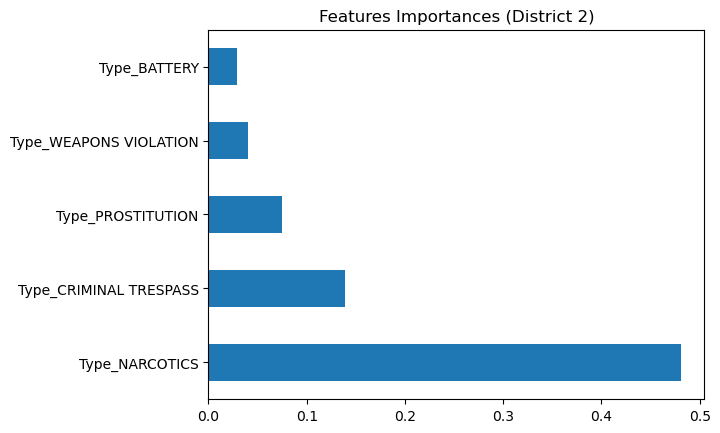

District  3
Accuracy: 0.7890714095067091
[[18913  2153]
 [ 6540 13607]]
              precision    recall  f1-score   support

           0       0.74      0.90      0.81     21066
           1       0.86      0.68      0.76     20147

    accuracy                           0.79     41213
   macro avg       0.80      0.79      0.79     41213
weighted avg       0.80      0.79      0.79     41213



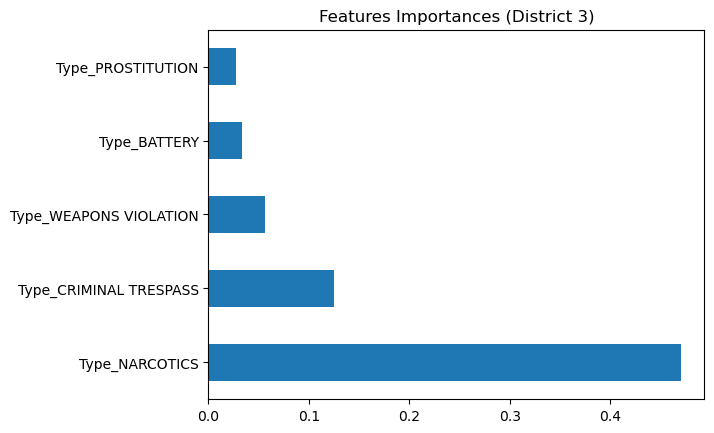

District  4
Accuracy: 0.7900049569645352
[[23811   881]
 [ 8439 11251]]
              precision    recall  f1-score   support

           0       0.74      0.96      0.84     24692
           1       0.93      0.57      0.71     19690

    accuracy                           0.79     44382
   macro avg       0.83      0.77      0.77     44382
weighted avg       0.82      0.79      0.78     44382



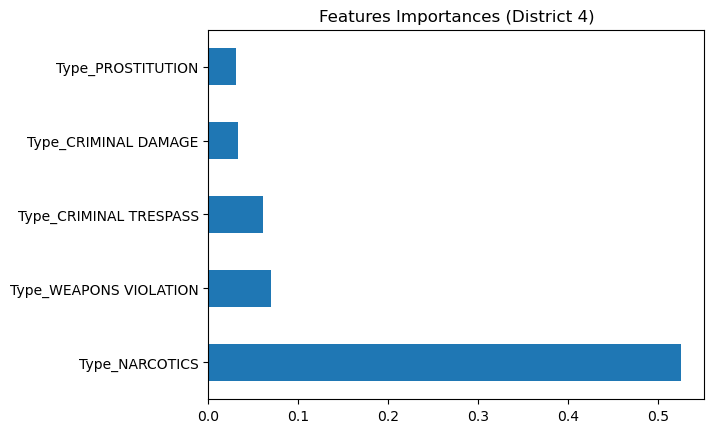

District  5
Accuracy: 0.7824537964818526
[[17346  1174]
 [ 6642 10766]]
              precision    recall  f1-score   support

           0       0.72      0.94      0.82     18520
           1       0.90      0.62      0.73     17408

    accuracy                           0.78     35928
   macro avg       0.81      0.78      0.77     35928
weighted avg       0.81      0.78      0.78     35928



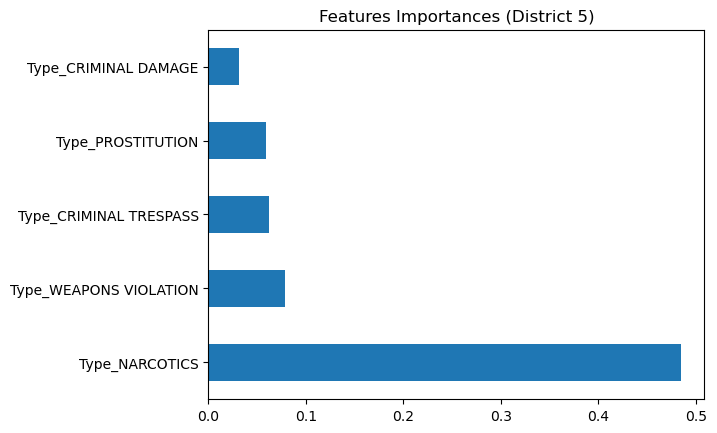

District  6
Accuracy: 0.778749370910921
[[23153   990]
 [ 9561 13984]]
              precision    recall  f1-score   support

           0       0.71      0.96      0.81     24143
           1       0.93      0.59      0.73     23545

    accuracy                           0.78     47688
   macro avg       0.82      0.78      0.77     47688
weighted avg       0.82      0.78      0.77     47688



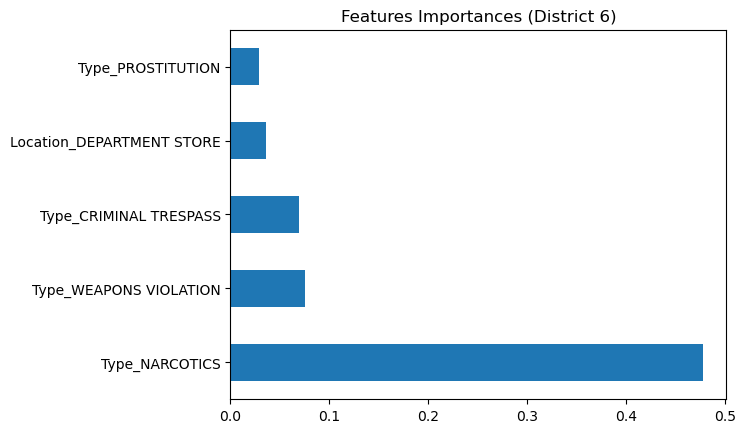

District  7
Accuracy: 0.7967898933416174
[[21925  1245]
 [ 8567 16548]]
              precision    recall  f1-score   support

           0       0.72      0.95      0.82     23170
           1       0.93      0.66      0.77     25115

    accuracy                           0.80     48285
   macro avg       0.82      0.80      0.79     48285
weighted avg       0.83      0.80      0.79     48285



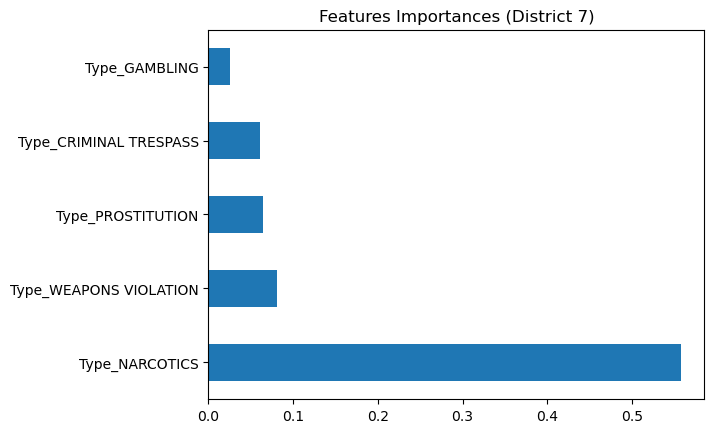

District  8
Accuracy: 0.785954447884809
[[26134  2923]
 [ 8345 15241]]
              precision    recall  f1-score   support

           0       0.76      0.90      0.82     29057
           1       0.84      0.65      0.73     23586

    accuracy                           0.79     52643
   macro avg       0.80      0.77      0.78     52643
weighted avg       0.79      0.79      0.78     52643



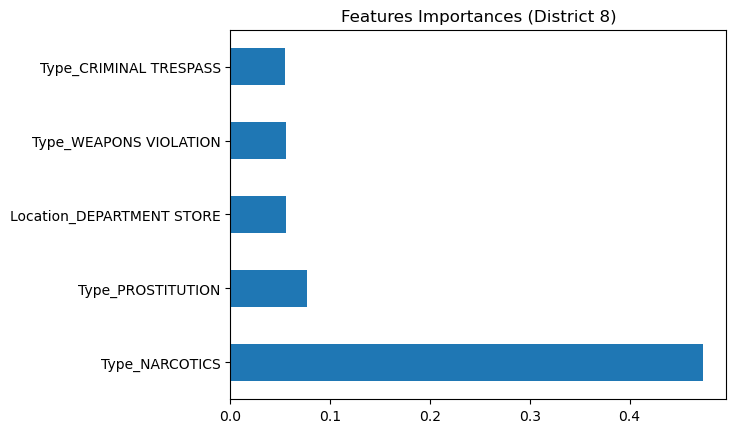

District  9
Accuracy: 0.7674018765043965
[[18867   893]
 [ 8577 12377]]
              precision    recall  f1-score   support

           0       0.69      0.95      0.80     19760
           1       0.93      0.59      0.72     20954

    accuracy                           0.77     40714
   macro avg       0.81      0.77      0.76     40714
weighted avg       0.81      0.77      0.76     40714



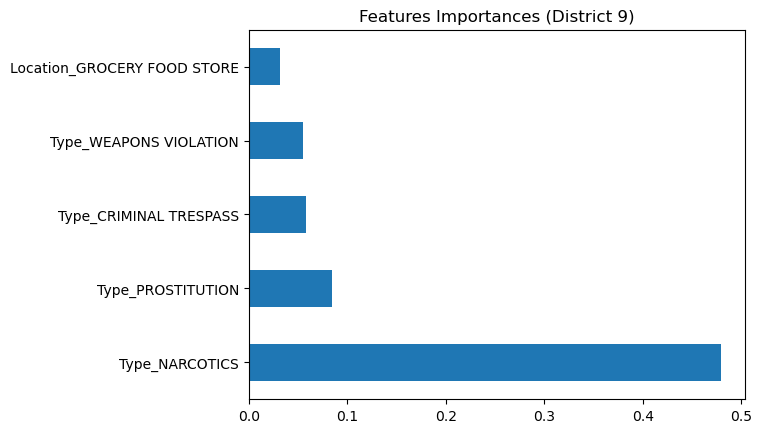

District  10
Accuracy: 0.794517998617536
[[14861  1558]
 [ 6171 15024]]
              precision    recall  f1-score   support

           0       0.71      0.91      0.79     16419
           1       0.91      0.71      0.80     21195

    accuracy                           0.79     37614
   macro avg       0.81      0.81      0.79     37614
weighted avg       0.82      0.79      0.79     37614



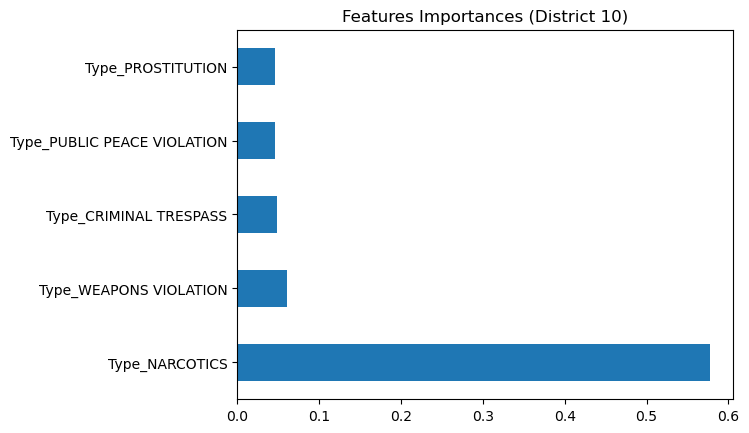

District  11
Accuracy: 0.8562177814548463
[[20057   625]
 [ 8412 33758]]
              precision    recall  f1-score   support

           0       0.70      0.97      0.82     20682
           1       0.98      0.80      0.88     42170

    accuracy                           0.86     62852
   macro avg       0.84      0.89      0.85     62852
weighted avg       0.89      0.86      0.86     62852



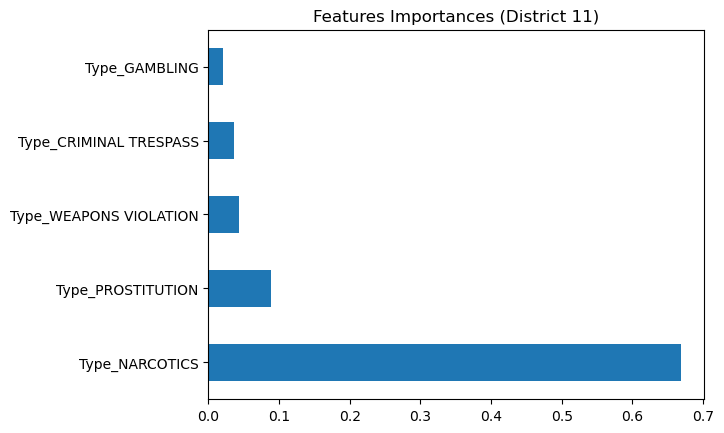

District  12
Accuracy: 0.7809650992578135
[[20740   617]
 [ 7912  9670]]
              precision    recall  f1-score   support

           0       0.72      0.97      0.83     21357
           1       0.94      0.55      0.69     17582

    accuracy                           0.78     38939
   macro avg       0.83      0.76      0.76     38939
weighted avg       0.82      0.78      0.77     38939



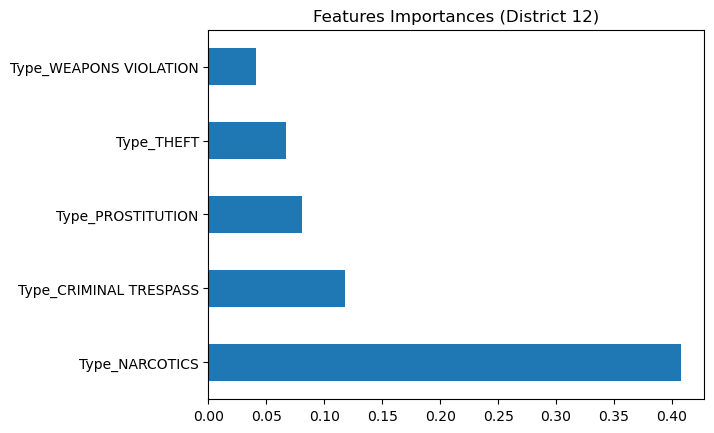

District  14
Accuracy: 0.7828112777607728
[[15957  1117]
 [ 5269  7060]]
              precision    recall  f1-score   support

           0       0.75      0.93      0.83     17074
           1       0.86      0.57      0.69     12329

    accuracy                           0.78     29403
   macro avg       0.81      0.75      0.76     29403
weighted avg       0.80      0.78      0.77     29403



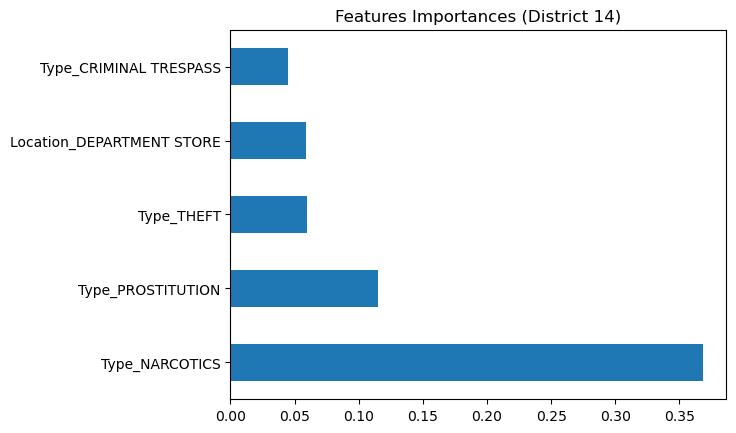

District  15
Accuracy: 0.8313605827201811
[[13526  1046]
 [ 5807 20258]]
              precision    recall  f1-score   support

           0       0.70      0.93      0.80     14572
           1       0.95      0.78      0.86     26065

    accuracy                           0.83     40637
   macro avg       0.83      0.85      0.83     40637
weighted avg       0.86      0.83      0.83     40637



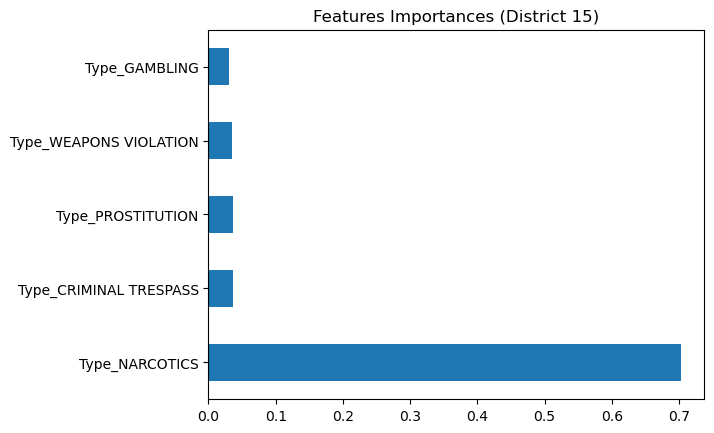

District  16
Accuracy: 0.7813217349281141
[[13818  1348]
 [ 4082  5583]]
              precision    recall  f1-score   support

           0       0.77      0.91      0.84     15166
           1       0.81      0.58      0.67      9665

    accuracy                           0.78     24831
   macro avg       0.79      0.74      0.75     24831
weighted avg       0.79      0.78      0.77     24831



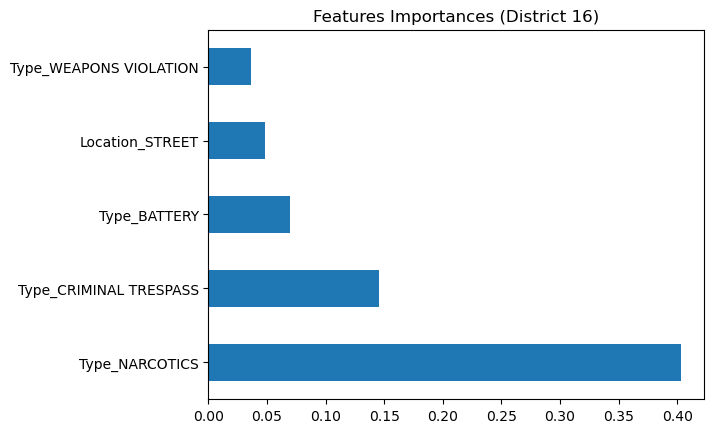

District  17
Accuracy: 0.7650985378258105
[[11314  1434]
 [ 3739  5535]]
              precision    recall  f1-score   support

           0       0.75      0.89      0.81     12748
           1       0.79      0.60      0.68      9274

    accuracy                           0.77     22022
   macro avg       0.77      0.74      0.75     22022
weighted avg       0.77      0.77      0.76     22022



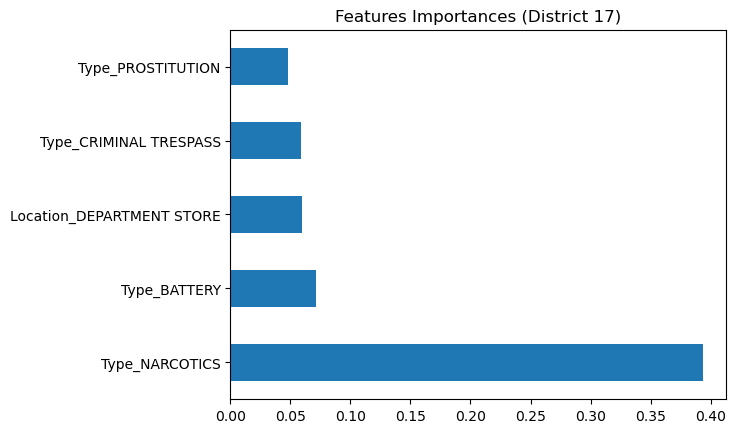

District  18
Accuracy: 0.7942469149715445
[[16895  2244]
 [ 5059 11296]]
              precision    recall  f1-score   support

           0       0.77      0.88      0.82     19139
           1       0.83      0.69      0.76     16355

    accuracy                           0.79     35494
   macro avg       0.80      0.79      0.79     35494
weighted avg       0.80      0.79      0.79     35494



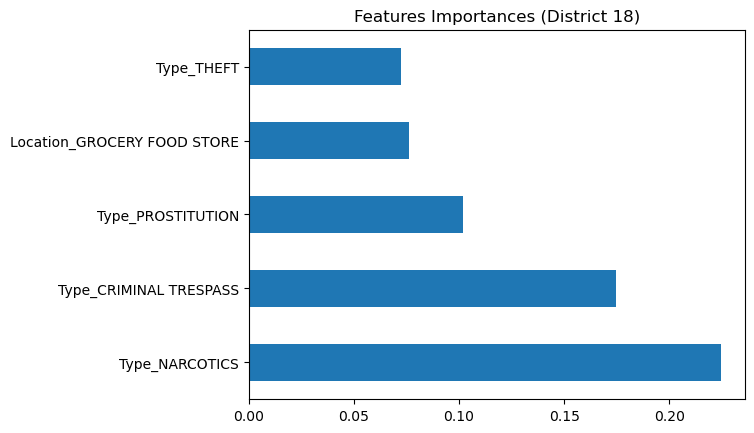

District  19
Accuracy: 0.7928318121039475
[[16241  3373]
 [ 3754 11034]]
              precision    recall  f1-score   support

           0       0.81      0.83      0.82     19614
           1       0.77      0.75      0.76     14788

    accuracy                           0.79     34402
   macro avg       0.79      0.79      0.79     34402
weighted avg       0.79      0.79      0.79     34402



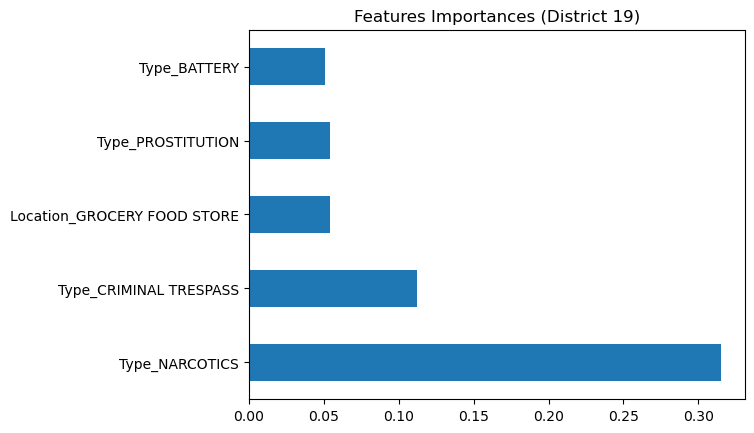

District  20
Accuracy: 0.7563213408466984
[[7244  356]
 [3017 3225]]
              precision    recall  f1-score   support

           0       0.71      0.95      0.81      7600
           1       0.90      0.52      0.66      6242

    accuracy                           0.76     13842
   macro avg       0.80      0.73      0.73     13842
weighted avg       0.79      0.76      0.74     13842



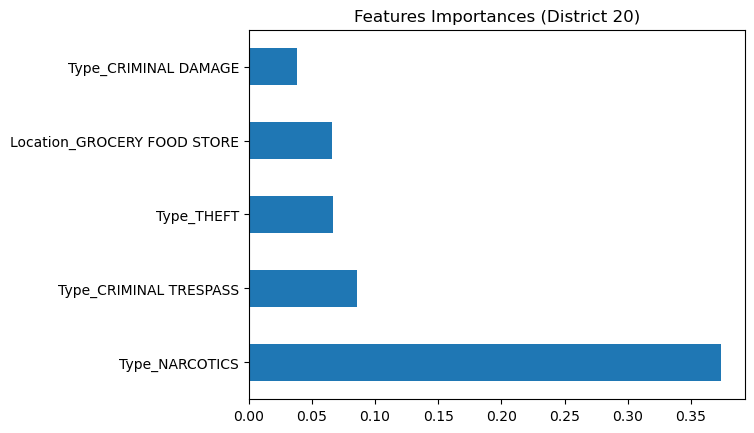

District  22
Accuracy: 0.7960463258785943
[[13752   601]
 [ 4506  6181]]
              precision    recall  f1-score   support

           0       0.75      0.96      0.84     14353
           1       0.91      0.58      0.71     10687

    accuracy                           0.80     25040
   macro avg       0.83      0.77      0.78     25040
weighted avg       0.82      0.80      0.79     25040



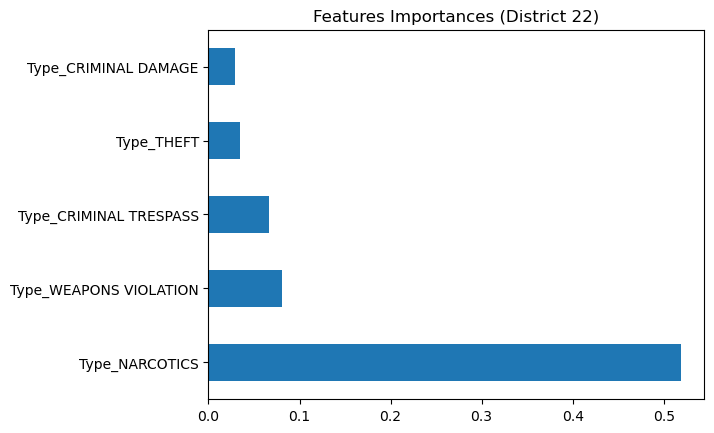

District  24
Accuracy: 0.7758025322931321
[[12564   564]
 [ 4695  5634]]
              precision    recall  f1-score   support

           0       0.73      0.96      0.83     13128
           1       0.91      0.55      0.68     10329

    accuracy                           0.78     23457
   macro avg       0.82      0.75      0.75     23457
weighted avg       0.81      0.78      0.76     23457



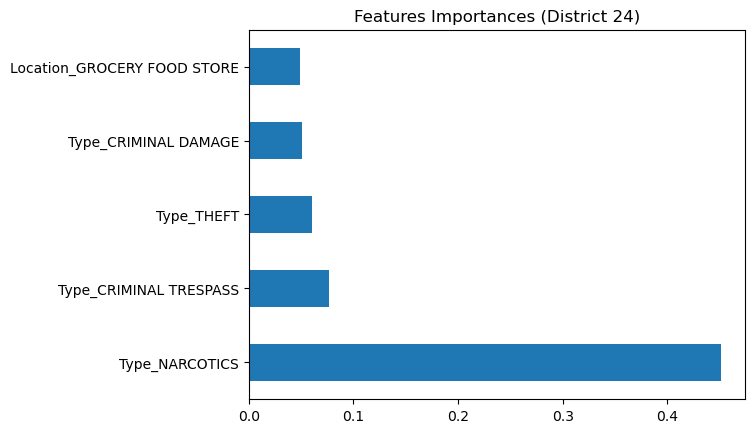

District  25
Accuracy: 0.7928157442201134
[[20808  2421]
 [ 7338 16536]]
              precision    recall  f1-score   support

           0       0.74      0.90      0.81     23229
           1       0.87      0.69      0.77     23874

    accuracy                           0.79     47103
   macro avg       0.81      0.79      0.79     47103
weighted avg       0.81      0.79      0.79     47103



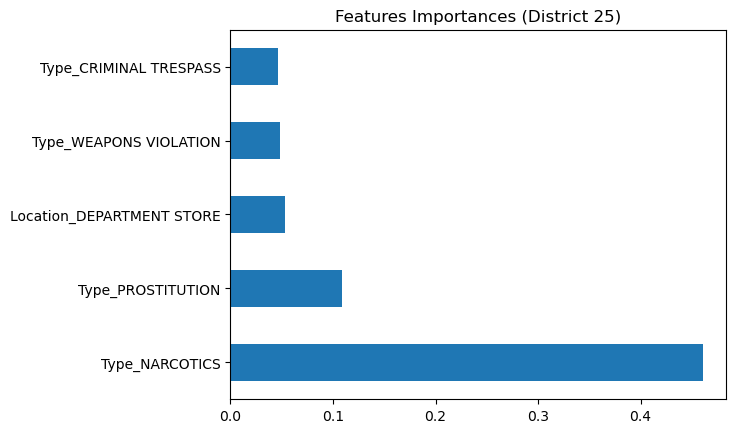

In [41]:
for i in [1,2,3,4,5,6,7,8,9,10,11,12,14,15,16,17,18,19,20,22,24,25]:
    df_tmp = df_balanced.loc[df_balanced["District"] == i]
    if not df_tmp.empty:
        print("District ", i)
        df_onehot_tmp_type = pd.get_dummies(df_tmp['Primary Type'], prefix='Type', dtype=np.int8)
        df_onehot_tmp_location = pd.get_dummies(df_tmp['Location Description'], prefix='Location', dtype=np.int8)
        df_onehot_tmp_domestic = df_tmp['Domestic'].astype(np.int8)
        df_onehot_tmp_day = pd.get_dummies(df_tmp['Day'], dtype=np.int8, prefix='Day')
        df_onehot_tmp_time = pd.get_dummies(df_tmp['Time'], dtype=np.int8, prefix='Time')
        df_onehot_tmp = pd.concat([df_onehot_tmp_type,df_onehot_tmp_location,df_onehot_tmp_domestic,df_onehot_tmp_day,df_onehot_tmp_time, df_tmp['Arrest'].astype(np.int8)], axis=1)
        
        # Split dataset in features and target variable
        col_len = len(df_onehot_tmp.columns)
        df_onehot_tmp.columns = df_onehot_tmp.columns.astype(str)
        feature_cols_tmp = df_onehot_tmp.columns[0:col_len-2] # Features
        X = df_onehot_tmp[feature_cols_tmp]
        y = df_onehot_tmp.Arrest # Target variable

        # Split dataset into training set and test set
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1) # 80% training and 20% test

        # Create Decision Tree classifer object
        clf = DecisionTreeClassifier(criterion="entropy",max_depth=15)

        # Train Decision Tree Classifer
        clf = clf.fit(X_train,y_train)

        # Predict the response for test dataset
        y_pred = clf.predict(X_test)

        # Model Accuracy, how often is the classifier correct?
        print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

        # Print confustion matrix and classification report
        print(confusion_matrix(y_test, y_pred))
        print(classification_report(y_test, y_pred))

        # Plot most important features
        feat_importances = pd.Series(clf.feature_importances_, index=feature_cols_tmp)
        feat_importances.nlargest(5).plot(kind='barh', title="Features Importances (District "+ str(i) + ")")
        plt.show()

## Applications

The results of this study will inform police districts in the City of Chicago when and where to deploy resources for crime prevention and response. The classification results also allow police districts to see which types of incidents have successfully led to an arrest and where they can improve. The data mining techniques described in this study may be applied to a visualization system where police and city administrators would have the ability to explore the data in more detail and automatically import the most recent data available.